# Global Stuffs

In [294]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
import re

## functions

In [295]:
def set_plot_style(axs, fonts, xlabel, ylabel):
    axs.set_xlabel(xlabel, fontsize=fonts)
    axs.set_ylabel(ylabel, fontsize=fonts)
    axs.tick_params(axis='both', which='major', direction='out', length=4, width=1)
    axs.tick_params(which='minor', width=1, size=2)  # Adjust size as needed
    axs.minorticks_on() # Turn on minor ticks
    
    #axs.grid(False, which='both', axis='both', linestyle='--', linewidth=0.5)
    axs.set_facecolor('white')
    axs.spines['top'].set_linewidth(1)
    axs.spines['right'].set_linewidth(1)
    axs.spines['bottom'].set_linewidth(1)
    axs.spines['left'].set_linewidth(1)
    axs.tick_params(axis='x', labelsize=fonts)
    axs.tick_params(axis='y', labelsize=fonts)

    return axs

def darken_colors(num_colors, darker_factor=0.7):
    colors = plt.cm.jet(np.linspace(0, 1, num_colors))
    darker_colors = colors.copy()

    for i in range(num_colors):
        rgb = darker_colors[i, :3]
        hsv = plt.cm.colors.rgb_to_hsv(rgb)
        hsv[2] *= darker_factor
        darker_colors[i, :3] = plt.cm.colors.hsv_to_rgb(hsv)

    return darker_colors


def create_label(filename):
    # Only modify if any target patterns exist
    if any(x in filename for x in ['thresh1_', 'f_', 'azimuthal', 'P3HB', 'rep_', '_01', 'subtracted_avg_']):
        label = filename.split('.')[0]
        label = label.replace('thresh1_', '').split('_Scan')[0]
        label = label.split('f_')[-1] if 'f_' in label else label
        label = label.split('_azimuthal')[0] if 'azimuthal' in label else label
        label = label.replace('P3HB', 'PHA-3B')
        label = label.replace('rep_', '').replace('_01', '')
        label = label.replace('subtracted_avg_', '')
    else:
        label = filename.split('.')[0]  # just remove extension, no other changes
    return label


## clear Intensity and interplote 

In [296]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

def remove_and_interpolate_q_range_pchip(q, I, qmin, qmax, label=None, show_plot=True):
    """
    Removes intensity values within a given q-range and interpolates over that range using PCHIP interpolation.

    Parameters:
    - q (np.ndarray): q-values
    - I (np.ndarray): Intensity values
    - qmin (float): Lower bound of q-range to remove
    - qmax (float): Upper bound of q-range to remove
    - label (str): Optional label for plotting
    - show_plot (bool): Whether to show the plot

    Returns:
    - q (np.ndarray): Original q-values
    - I_interp (np.ndarray): Intensity with interpolated region
    """
    I_interp = I.copy()
    mask_remove = (q >= qmin) & (q <= qmax)

    # Indices before and after the gap
    idx_before = np.where(q < qmin)[0][-1] if np.any(q < qmin) else None
    idx_after = np.where(q > qmax)[0][0] if np.any(q > qmax) else None

    if idx_before is not None and idx_after is not None:
        # Known q and I points (excluding the gap)
        q_known = np.concatenate((q[:idx_before+1], q[idx_after:]))
        I_known = np.concatenate((I[:idx_before+1], I[idx_after:]))

        # Create PCHIP interpolator
        interpolator = PchipInterpolator(q_known, I_known)

        # Fill in the missing region
        q_interp = q[mask_remove]
        I_interp[mask_remove] = interpolator(q_interp)

        if show_plot:
            plt.figure(figsize=(6.5, 6))
            plt.plot(q, I, label='Original', alpha=0.5)
            plt.plot(q, I_interp, label='PCHIP Interpolated', linewidth=2)
            plt.plot(q[mask_remove], I_interp[mask_remove], 'k--', label='Interpolated Region')
            plt.xlabel('q [nm⁻¹]')
            plt.ylabel('Intensity [a.u.]')
            plt.title(label if label else 'Interpolated Intensity')
            plt.legend()
            plt.tight_layout()
            plt.show()
    else:
        print("Warning: Cannot interpolate — qmin or qmax is outside the q range.")

    return q, I_interp



# functions for h5 files

# clean and interplote the data

In [297]:
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt

def remove_and_interpolate_cubic_spline_q_range(q, I, qmin, qmax, label=None, show_plot=True):
    """
    Removes intensity values within a given q-range and interpolates over that range using CubicSpline interpolation.

    Parameters:
    - q (np.ndarray): q-values
    - I (np.ndarray): Intensity values
    - qmin (float): Lower bound of q-range to remove
    - qmax (float): Upper bound of q-range to remove
    - label (str): Optional label for plotting
    - show_plot (bool): Whether to show the plot

    Returns:
    - q (np.ndarray): Original q-values
    - I_interp (np.ndarray): Intensity with interpolated region
    """
    I_interp = I.copy()
    mask_remove = (q >= qmin) & (q <= qmax)

    # Indices before and after the gap
    idx_before = np.where(q < qmin)[0][-1] if np.any(q < qmin) else None
    idx_after = np.where(q > qmax)[0][0] if np.any(q > qmax) else None

    if idx_before is not None and idx_after is not None:
        # Known q and I points (excluding the gap)
        q_known = np.concatenate((q[:idx_before+1], q[idx_after:]))
        I_known = np.concatenate((I[:idx_before+1], I[idx_after:]))

        # Remove non-finite points before interpolation
        finite_mask = np.isfinite(q_known) & np.isfinite(I_known)
        q_known = q_known[finite_mask]
        I_known = I_known[finite_mask]

        # Now safe to interpolate
        interpolator = CubicSpline(q_known, I_known)

        # Fill in the missing region
        q_interp = q[mask_remove]
        I_interp[mask_remove] = interpolator(q_interp)

        if show_plot:
            plt.figure(figsize=(6.5, 6))
            plt.plot(q, I, label='Original', alpha=0.5)
            plt.plot(q, I_interp, label='CubicSpline Interpolated', linewidth=2)
            plt.plot(q[mask_remove], I_interp[mask_remove], 'k--', label='Interpolated Region')
            plt.xlabel('q [nm⁻¹]')
            plt.ylabel('Intensity [a.u.]')
            plt.title(label if label else 'Interpolated Intensity')
            plt.legend()
            plt.tight_layout()
            plt.show()
    else:
        print("Warning: Cannot interpolate — qmin or qmax is outside the q range.")

    return q, I_interp


# Akima1Interplote

In [298]:
from scipy.interpolate import Akima1DInterpolator
import numpy as np
import matplotlib.pyplot as plt

def remove_and_interpolate_q_range(q, I, qmin, qmax, label=None, show_plot=True):
    I_interp = I.copy()
    mask_remove = (q >= qmin) & (q <= qmax)

    idx_before = np.where(q < qmin)[0][-1] if np.any(q < qmin) else None
    idx_after = np.where(q > qmax)[0][0] if np.any(q > qmax) else None

    if idx_before is not None and idx_after is not None:
        q_known = np.concatenate((q[:idx_before+1], q[idx_after:]))
        I_known = np.concatenate((I[:idx_before+1], I[idx_after:]))

        # Remove any non-finite values
        finite_mask = np.isfinite(q_known) & np.isfinite(I_known)
        q_known = q_known[finite_mask]
        I_known = I_known[finite_mask]

        # Use Akima interpolator
        interpolator = Akima1DInterpolator(q_known, I_known)

        q_interp = q[mask_remove]
        I_interp[mask_remove] = interpolator(q_interp)

        if show_plot:
            plt.figure(figsize=(6.5, 6))
            plt.plot(q, I, label='Original', alpha=0.5)
            plt.plot(q, I_interp, label='Akima Interpolated', linewidth=2)
            plt.plot(q[mask_remove], I_interp[mask_remove], 'k--', label='Interpolated Region')
            plt.xlabel('q [nm⁻¹]')
            plt.ylabel('Intensity [a.u.]')
            plt.title(label if label else 'Interpolated Intensity')
            plt.legend()
            plt.tight_layout()
            plt.show()
    else:
        print("Warning: Cannot interpolate — qmin or qmax is outside the q range.")

    return q, I_interp


## pchip interpolation an dclean

In [299]:
def remove_and_interpolate_q_range_pchip(q, I, qmin, qmax, label=None, show_plot=True):
    """
    Removes intensity values within a given q-range and interpolates over that range using PCHIP interpolation.

    Parameters:
    - q (np.ndarray): q-values
    - I (np.ndarray): Intensity values
    - qmin (float): Lower bound of q-range to remove
    - qmax (float): Upper bound of q-range to remove
    - label (str): Optional label for plotting
    - show_plot (bool): Whether to show the plot

    Returns:
    - q (np.ndarray): Original q-values
    - I_interp (np.ndarray): Intensity with interpolated region
    """
    I_interp = I.copy()
    mask_remove = (q >= qmin) & (q <= qmax)

    # Indices before and after the gap
    idx_before = np.where(q < qmin)[0][-1] if np.any(q < qmin) else None
    idx_after = np.where(q > qmax)[0][0] if np.any(q > qmax) else None

    if idx_before is not None and idx_after is not None:
        # Known q and I points (excluding the gap)
        q_known = np.concatenate((q[:idx_before+1], q[idx_after:]))
        I_known = np.concatenate((I[:idx_before+1], I[idx_after:]))

        # Create PCHIP interpolator
        interpolator = PchipInterpolator(q_known, I_known)

        # Fill in the missing region
        q_interp = q[mask_remove]
        I_interp[mask_remove] = interpolator(q_interp)

        if show_plot:
            plt.figure(figsize=(6.5, 6))
            plt.plot(q, I, label='Original', alpha=0.5)
            plt.plot(q, I_interp, label='PCHIP Interpolated', linewidth=2)
            plt.plot(q[mask_remove], I_interp[mask_remove], 'k--', label='Interpolated Region')
            plt.xlabel('q [nm⁻¹]')
            plt.ylabel('Intensity [a.u.]')
            plt.title(label if label else 'Interpolated Intensity')
            plt.legend()
            plt.tight_layout()
            plt.show()
    else:
        print("Warning: Cannot interpolate — qmin or qmax is outside the q range.")

    return q, I_interp

In [300]:
def extract_numbers(filename):
    match = re.search(r'_s(\d+)_0*(\d+)', filename)
    if match:
        snumber = int(match.group(1))
        number = int(match.group(2))
        return snumber, number
    return None, None



def extract_numbers(filename):
    import re
    match = re.search(r'_s(\d+)_0*(\d+)', filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

def set_plot_style(axs, fonts, xlabel, ylabel):
    axs.set_xlabel(xlabel, fontsize=fonts)
    axs.set_ylabel(ylabel, fontsize=fonts)
    axs.tick_params(axis='both', which='major', direction='out', length=4, width=1)
    axs.tick_params(which='both', width=1, size=2)  # Adjust size as needed
    #axs.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    axs.minorticks_on()  # Enable minor ticks
    axs.set_facecolor('white')
    axs.spines['top'].set_linewidth(1)
    axs.spines['right'].set_linewidth(1)
    axs.spines['bottom'].set_linewidth(1)
    axs.spines['left'].set_linewidth(1)
    axs.tick_params(axis='x', labelsize=fonts)
    axs.tick_params(axis='y', labelsize=fonts)
    return axs

def extract_data_from_hdf5(file_path, target_number, snumber_range, is_radial):
    data = []

    with h5py.File(file_path, 'r') as hf:
        for key in hf.keys():
            group = hf[key]
            filename = group['filename'][()].decode('utf-8')
            snumber, number = extract_numbers(filename)

            if snumber is None or not (snumber_range[0] <= snumber <= snumber_range[1]):
                continue

            if is_radial:
                chi = group['chi'][:]
                I = group['I'][:]
                real_date_time = group['real_date_time'][()].decode('utf-8') if 'real_date_time' in group else ''
                i0 = group['i0'][()] if 'i0' in group else None
                i1 = group['i1'][()] if 'i1' in group else None
                Photod = group['Photod'][()] if 'Photod' in group else None
                if number == target_number:
                    data.append((chi, I, filename, real_date_time, i0, i1, Photod, snumber))
            else:
                q = group['q'][:]
                I = group['I'][:]
                err = group['error'][:]
                real_date_time = group['real_date_time'][()].decode('utf-8') if 'real_date_time' in group else ''
                i0 = group['i0'][()] if 'i0' in group else None
                i1 = group['i1'][()] if 'i1' in group else None
                Photod = group['Photod'][()] if 'Photod' in group else None
                if number == target_number:
                    data.append((q, I, err, filename, real_date_time, i0, i1, Photod, snumber))

    return data



def darken_colors(num_colors, darker_factor=0.7):
    colors = plt.cm.jet(np.linspace(0, 1, num_colors))
    darker_colors = colors.copy()

    for i in range(num_colors):
        rgb = darker_colors[i, :3]
        hsv = plt.cm.colors.rgb_to_hsv(rgb)
        hsv[2] *= darker_factor
        darker_colors[i, :3] = plt.cm.colors.hsv_to_rgb(hsv)

    return darker_colors

def plot_waterfall(file_path, data, is_radial, chi_mask_range=(83, 88), offset_step=0.5):
    
    # print last file folder name from filepath
    file_tmp = file_path.split('/')
    print(f'{file_tmp[-1]}')

    
    """
    Generates a waterfall plot based on extracted data.

    Parameters:
        data (list): List of tuples containing the data to plot.
        is_radial (bool): Whether the data is radial (True) or azimuthal (False).
        offset_step (float): Step size for vertically offsetting each line in the waterfall plot.
    """
    num_colors = len(data)
    colors = darken_colors(num_colors)

    # Sort data by snumber
    data.sort(key=lambda x: x[-1])

    # Plot final results if plotting is enabled
    # file path 2 folderup to save the data and figures
    file_path_save = file_path.split('/')
    file_path_save = '/'.join(file_path_save[:-2])
    # create a foldername figures within the save-path_folder
    file_path_save = file_path_save + '/figures'
    if not os.path.exists(file_path_save):
        os.makedirs(file_path_save)
        

    plt.figure(figsize=(6, 6))
    for i, entry in enumerate(data):
        if is_radial:
            chi, I, filename, real_date_time, i0, i1, Photod, snumber = entry

            chi_rad = np.deg2rad(chi) if np.max(chi) > 2 * np.pi else chi
            chi_shifted_rad = (chi_rad + np.pi / 2) % (2 * np.pi)
            shift_amount = int(len(chi) * (np.pi / 2) / (2 * np.pi))
            I_shifted = np.roll(I, shift=shift_amount)
            mask_non_zero = I_shifted != 0
            chi_filtered = -chi[mask_non_zero]
            I_filtered = I_shifted[mask_non_zero]
            mask = (chi_filtered < chi_mask_range[0]) | (chi_filtered > chi_mask_range[1])
            chi_filtered = chi_filtered[mask]
            I_filtered = I_filtered[mask]
            #norm to total sum of intensity
            I_filtered_norm = (I_filtered / np.sum(I_filtered))*1000


            plt.plot(chi_filtered, I_filtered + i * offset_step ,label=f'Snumber: {snumber}', color=colors[i],alpha=0.5)
        else:
            q, I, err, filename, real_date_time, i0, i1, Photod, snumber = entry
            plt.plot(q, I + i * offset_step, '-',label=f'Snumber: {snumber}', color=colors[i], alpha=0.5)
    
    plt.xlabel('Chi [deg]' if is_radial else 'q [nm^-1]')
    plt.ylabel('Intensity')
    # set the x-axis limits for isradial true or false
    if is_radial:
        plt.xlim(30, 135)
    else:
        plt.xlim(5, 32)

    
    #plt.xlim(5, 32)    

    #plt.title('Waterfall Plot of Subtracted Data')
    #plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    set_plot_style(plt.gca(), 20, 'Chi' if is_radial else 'q [nm^-1]', 'Intensity')
    #plt.grid(True)
    plt.tight_layout()

    # Save the figure for is_radial true or false
    if is_radial:
        plt.savefig(f'{file_path_save}/waterfall_plot_radial.png', dpi=300)
    else:

        plt.savefig(f'{file_path_save}/waterfall_plot_azimuthal.png', dpi=300)
    
    plt.show()

 


# general read functions for h5 files

In [301]:
import h5py
import numpy as np

def safe_decode(val):
    if isinstance(val, bytes):
        return val.decode('utf-8')
    elif isinstance(val, np.ndarray):
        if val.dtype.kind in {'S', 'O'} and val.size == 1:
            return str(val[0], 'utf-8') if isinstance(val[0], bytes) else str(val[0])
        elif val.dtype.kind == 'U':
            return str(val[0])
        else:
            return str(val)
    else:
        return str(val)


def extract_data_from_hdf5_general(file_path, target_number=None, snumber_range=None, is_radial=True):
    data = []

    try:
        with h5py.File(file_path, 'r') as hf:
            print(f"Opened file: {file_path}")
            keys = list(hf.keys())
            print(f"Top-level groups: {keys}")

            for key in keys:
                print(f"\nReading group: {key}")
                group = hf[key]

                # List subkeys in this group
                subkeys = list(group.keys())
                print(f"Subkeys in group '{key}': {subkeys}")

                # filename
                filename = ''
                if 'filename' in group:
                    try:
                        raw = group['filename'][()]
                        filename = safe_decode(raw)
                        print(f"Filename: {filename}")
                    except Exception as e:
                        print(f"Error decoding filename in group '{key}': {e}")
                        continue
                else:
                    print(f"'filename' not found in group '{key}'")
                    continue

                # extract numbers
                try:
                    snumber, number = extract_numbers(filename)
                except Exception as e:
                    print(f"Error extracting numbers from filename '{filename}': {e}")
                    continue

                # Filters
                if snumber_range is not None:
                    if snumber is None or not (snumber_range[0] <= snumber <= snumber_range[1]):
                        print(f"snumber {snumber} out of range {snumber_range}, skipping")
                        continue
                if target_number is not None and number != target_number:
                    print(f"number {number} does not match target {target_number}, skipping")
                    continue

                # real_date_time
                real_date_time = 'N/A'
                if 'real_date_time' in group:
                    try:
                        real_date_time = safe_decode(group['real_date_time'][()])
                    except Exception as e:
                        print(f"Error decoding 'real_date_time' in group '{key}': {e}")
                elif 'timestamp' in group:
                    try:
                        real_date_time = safe_decode(group['timestamp'][()])
                    except Exception as e:
                        print(f"Error decoding 'timestamp' in group '{key}': {e}")
                print(f"real_date_time: {real_date_time}")

                # Scalars
                i0 = group['i0'][()] if 'i0' in group else None
                i1 = group['i1'][()] if 'i1' in group else None
                Photod = group['Photod'][()] if 'Photod' in group else None
                print(f"i0: {i0}, i1: {i1}, Photod: {Photod}")

                try:
                    x = group['x'][:] if 'x' in group else np.array([])
                    I = group['I'][:] if 'I' in group else np.array([])
                    print(f"x shape: {x.shape}, I shape: {I.shape}")
                    
                    if 'error' in group:
                        err = group['error'][:]
                        print(f"error shape: {err.shape}")
                    else:
                        err = np.sqrt((I))
                        print("Computed error as sqrt of I.")
                    data.append((x, I, err, filename, real_date_time, i0, i1, Photod, snumber))

                except Exception as e:
                    print(f"Error extracting intensity data in group '{key}': {e}")
                    continue

    except Exception as e:
        print(f"Error opening HDF5 file '{file_path}': {e}")

    # Sort the data by snumber (last element in each tuple)
    data.sort(key=lambda entry: entry[-1] if entry[-1] is not None else -1)

    print(f"\nTotal entries extracted: {len(data)}")
    return data


## write excel files

## read and plot excel files

In [302]:
import os
from tkinter import font
import pandas as pd
import matplotlib.pyplot as plt

def create_label(filename):
    # Only modify if any target patterns exist
    if any(x in filename for x in ['thresh1_', 'f_', 'azimuthal', 'P3HB', 'rep_', '_01', 'subtracted_avg_']):
        label = filename.split('.')[0]
        label = label.replace('thresh1_', '').split('_Scan')[0]
        label = label.split('f_')[-1] if 'f_' in label else label
        label = label.split('_azimuthal')[0] if 'azimuthal' in label else label
        label = label.replace('P3HB', 'PHA-3B')
        label = label.replace('rep_', '').replace('_01', '')
        label = label.replace('subtracted_avg_', '')
    else:
        label = filename.split('.')[0]  # just remove extension, no other changes
    return label
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def plot_excel_data_and_plot(folder_path, keywords, xlim=(0, 20)):
    """
    Read Excel files from the folder matching the keywords and plot their data on one figure with continuous colors.
    
    Parameters:
    folder_path (str): The path of the folder containing the Excel files.
    keywords (list): List of keywords to match in the filename.
    """
    # List to hold the DataFrames for plotting
    data_frames = []

    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"Folder path '{folder_path}' does not exist.")
        return

    # Convert keywords to lowercase for case-insensitive matching
    keywords = [keyword.lower() for keyword in keywords]

    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        filename_lower = filename.lower()
        
        if filename_lower.endswith('.xlsx') and any(keyword in filename_lower for keyword in keywords):
            print(f"Matching file: {filename}")  # Debugging output
            file_path = os.path.join(folder_path, filename)
            df = pd.read_excel(file_path)
            
            if 'q' in df.columns and 'I_detrand' in df.columns:
                label = create_label(filename)  # Assuming you have a create_label() function
                data_frames.append((df, label))

    if not data_frames:
        print("No files matched the criteria.")
        return

    # Create the plot
    plt.figure(figsize=(8, 6), dpi=300)

    # Create a colormap (e.g., 'plasma') but do not overwrite it
    cmap = plt.get_cmap('plasma')  # Built-in colormap
    
    # Generate darkened colors using the colormap
    darkened_colors = darken_colors(len(data_frames), 0.8)  # Darken the colors separately

    # Loop through the DataFrames and plot
    thickness = [1000,180,120,120,50,30,15 ]
    for idx, (df, label) in enumerate(data_frames):
        q = df['q']
        I = df['I_detrand']
        I = 1000 * I / np.sum(I)  # Normalize
        #I = I / thickness[idx]

        # Use the darkened color for this plot
        color = darkened_colors[idx]  # Use darkened color from the list
        plt.plot(q, I, 'o-', markersize=3, label=label, color=color)

    plt.xlabel('q [nm⁻¹]')
    plt.ylabel('Intensity [a.u.]')
    plt.xlim(xlim)
    set_plot_style(plt.gca(), 20, 'q [nm⁻¹]', 'Intensity [a.u.]')  # Assuming you have set_plot_style
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


# Determine Crystllinity and peak position

function 1: determine crystallinity


In [303]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 30 16:05:47 2015

@author: M Wieser

LICENCE
This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Lesser General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>
"""


import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.linalg import cholesky
# from scikits.sparse.cholmod import cholesky
from scipy import sparse

from scipy.stats import norm
import matplotlib.pyplot as pl


def als(y, lam=1e6, p=0.1, itermax=10):
    r"""
    Implements an Asymmetric Least Squares Smoothing
    baseline correction algorithm (P. Eilers, H. Boelens 2005)

    Baseline Correction with Asymmetric Least Squares Smoothing
    based on https://github.com/vicngtor/BaySpecPlots

    Baseline Correction with Asymmetric Least Squares Smoothing
    Paul H. C. Eilers and Hans F.M. Boelens
    October 21, 2005

    Description from the original documentation:

    Most baseline problems in instrumental methods are characterized by a smooth
    baseline and a superimposed signal that carries the analytical information: a series
    of peaks that are either all positive or all negative. We combine a smoother
    with asymmetric weighting of deviations from the (smooth) trend get an effective
    baseline estimator. It is easy to use, fast and keeps the analytical peak signal intact.
    No prior information about peak shapes or baseline (polynomial) is needed
    by the method. The performance is illustrated by simulation and applications to
    real data.


    Inputs:
        y:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        p:
            wheighting deviations. 0.5 = symmetric, <0.5: negative
            deviations are stronger suppressed
        itermax:
            number of iterations to perform
    Output:
        the fitted background vector

    """
    L = len(y)
#  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    D = sparse.eye(L, format='csc')
    D = D[1:] - D[:-1]  # numpy.diff( ,2) does not work with sparse matrix. This is a workaround.
    D = D[1:] - D[:-1]
    D = D.T
    w = np.ones(L)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(L, L))
        Z = W + lam * D.dot(D.T)
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z


def arpls(y, lam=1e4, ratio=0.05, itermax=100):
    r"""
    Baseline correction using asymmetrically
    reweighted penalized least squares smoothing
    Sung-June Baek, Aaron Park, Young-Jin Ahna and Jaebum Choo,
    Analyst, 2015, 140, 250 (2015)

    Abstract

    Baseline correction methods based on penalized least squares are successfully
    applied to various spectral analyses. The methods change the weights iteratively
    by estimating a baseline. If a signal is below a previously fitted baseline,
    large weight is given. On the other hand, no weight or small weight is given
    when a signal is above a fitted baseline as it could be assumed to be a part
    of the peak. As noise is distributed above the baseline as well as below the
    baseline, however, it is desirable to give the same or similar weights in
    either case. For the purpose, we propose a new weighting scheme based on the
    generalized logistic function. The proposed method estimates the noise level
    iteratively and adjusts the weights correspondingly. According to the
    experimental results with simulated spectra and measured Raman spectra, the
    proposed method outperforms the existing methods for baseline correction and
    peak height estimation.

    Inputs:
        y:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        ratio:
            wheighting deviations: 0 < ratio < 1, smaller values allow less negative values
        itermax:
            number of iterations to perform
    Output:
        the fitted background vector

    """
    N = len(y)
#  D = sparse.csc_matrix(np.diff(np.eye(N), 2))
    D = sparse.eye(N, format='csc')
    D = D[1:] - D[:-1]  # numpy.diff( ,2) does not work with sparse matrix. This is a workaround.
    D = D[1:] - D[:-1]

    H = lam * D.T * D
    w = np.ones(N)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(N, N))
        WH = sparse.csc_matrix(W + H)
        C = sparse.csc_matrix(cholesky(WH.todense()))
        z = spsolve(C, spsolve(C.T, w * y))
        d = y - z
        dn = d[d < 0]
        m = np.mean(dn)
        s = np.std(dn)
        wt = 1. / (1 + np.exp(2 * (d - (2 * s - m)) / s))
        if np.linalg.norm(w - wt) / np.linalg.norm(w) < ratio:
            break
        w = wt
    return z



def WhittakerSmooth(x, w, lam, differences=1):
    '''
    Penalized least squares algorithm for background fitting

    input
        x:
            input data (i.e. chromatogram of spectrum)
        w:
            binary masks (value of the mask is zero if a point belongs to peaks
            and one otherwise)
        lam:
            parameter that can be adjusted by user. The larger lambda is,  the
            smoother the resulting background
        differences:
            integer indicating the order of the difference of penalties

    output:
        the fitted background vector
    '''
    X = np.matrix(x)
    m = X.size
#    D = csc_matrix(np.diff(np.eye(m), differences))
    D = sparse.eye(m, format='csc')
    for i in range(differences):
        D = D[1:] - D[:-1]  # numpy.diff() does not work with sparse matrix. This is a workaround.
    W = sparse.diags(w, 0, shape=(m, m))
    A = sparse.csc_matrix(W + (lam * D.T * D))
    B = sparse.csc_matrix(W * X.T)
    background = spsolve(A, B)
    return np.array(background)



def airpls(x, lam=100, porder=1, itermax=100):
    '''
    airpls.py Copyright 2014 Renato Lombardo - renato.lombardo@unipa.it
    Baseline correction using adaptive iteratively reweighted penalized least squares

    This program is a translation in python of the R source code of airPLS version 2.0
    by Yizeng Liang and Zhang Zhimin - https://code.google.com/p/airpls
    Reference:
    Z.-M. Zhang, S. Chen, and Y.-Z. Liang, Baseline correction using adaptive
    iteratively reweighted penalized least squares. Analyst 135 (5), 1138-1146 (2010).

    Description from the original documentation:

    Baseline drift always blurs or even swamps signals and deteriorates analytical
    results, particularly in multivariate analysis.  It is necessary to correct
    baseline drift to perform further data analysis. Simple or modified polynomial
    fitting has been found to be effective in some extent. However, this method
    requires user intervention and prone to variability especially in low
    signal-to-noise ratio environments. The proposed adaptive iteratively
    reweighted Penalized Least Squares (airPLS) algorithm doesn't require any
    user intervention and prior information, such as detected peaks. It
    iteratively changes weights of sum squares errors (SSE) between the fitted
    baseline and original signals, and the weights of SSE are obtained adaptively
    using between previously fitted baseline and original signals. This baseline
    estimator is general, fast and flexible in fitting baseline.

    Adaptive iteratively reweighted penalized least squares for baseline fitting

    input
        x:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        porder:
            integer indicating the order of the difference of penalties

    output:
        the fitted background vector
    '''
    m = x.shape[0]
    w = np.ones(m)
    for i in range(1, itermax + 1):
        z = WhittakerSmooth(x, w, lam, porder)
        d = x - z
        dssn = np.abs(d[d < 0].sum())
        if(dssn < 0.001 * (abs(x)).sum() or i == itermax):
            if(i == itermax):
                print('airpls: max iteration reached!')
            break
        w[d >= 0] = 0  # d>0 means that this point is part of a peak,
        # so its weight is set to 0 in order to ignore it
        w[d < 0] = np.exp(i * np.abs(d[d < 0]) / dssn)
        w[0] = np.exp(i * (d[d < 0]).max() / dssn)
        w[-1] = w[0]
    return z





import math

def calculate_percentage_crystal(area_I_sub, area_I_smoothed, delta_area_I_sub, delta_area_I_smoothed):
    # Calculate the percentage_crystal
    percentage_crystal = (area_I_sub / (area_I_sub + area_I_smoothed)) * 100
    
    # Calculate the relative uncertainty using the formula
    relative_uncertainty = math.sqrt((delta_area_I_sub / area_I_sub)**2 + ((delta_area_I_sub / (area_I_sub + area_I_smoothed)) + (delta_area_I_smoothed / (area_I_sub + area_I_smoothed)))**2)
    
    # Calculate the error in percentage_crystal
    delta_percentage_crystal = relative_uncertainty * percentage_crystal
    
    return percentage_crystal, delta_percentage_crystal





import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian_radial(x, amplitude, center, sigma):
    return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))

def lorentzian_radial(x, amplitude, center, gamma):
    return (amplitude * (gamma**2)) / ((x - center)**2 + gamma**2)

def fit_radial_peak(x, y, distribution='gaussian'):
    if distribution.lower() == 'gaussian':
        model_func = gaussian_radial
        initial_guess = [np.max(y), x[np.argmax(y)], (x[-1] - x[0]) / 4]  # Amplitude, center, and standard deviation
        bounds = ([0, np.min(x), 0], [np.inf, np.max(x), np.inf])  # Ensure positive amplitude and sigma
    elif distribution.lower() == 'lorentzian':
        model_func = lorentzian_radial
        initial_guess = [np.max(y), x[np.argmax(y)], (x[-1] - x[0]) / 4]  # Amplitude, center, and gamma
        bounds = ([0, np.min(x), 0], [np.inf, np.max(x), np.inf])  # Ensure positive amplitude and gamma
    else:
        raise ValueError("Distribution must be either 'gaussian' or 'lorentzian'.")

    popt, pcov = curve_fit(model_func, x, y, p0=initial_guess, bounds=bounds)
    peak_position = popt[1]
    if distribution.lower() == 'gaussian':
        fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]
    elif distribution.lower() == 'lorentzian':
        fwhm = 2 * popt[2]


    return peak_position, fwhm, model_func(x, *popt), model_func, popt




def smooth_data(input_array, window_size=3):
    """
    Smooth the input array using a simple moving average.

    Parameters:
    - input_array: numpy array
        The input array to be smoothed.
    - window_size: int, optional (default: 3)
        The size of the moving average window.

    Returns:
    - smoothed_array: numpy array
        The smoothed array with the same length as the input array.
    """
    cumsum = np.cumsum(input_array, dtype=float)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    smoothed_array = cumsum[window_size - 1:] / window_size

    # Pad the beginning of the array to maintain the same length
    pad_size = window_size - 1
    pad_values = np.cumsum(input_array[:pad_size], dtype=float)
    pad_values /= np.arange(1, pad_size + 1)
    smoothed_array = np.concatenate((pad_values, smoothed_array))

    return smoothed_array


 ## Function 2: determine crystallinity

In [304]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import h5py
import pandas as pd
from datetime import date, time
import datetime

def analysis_hdf5_data(file_path, is_radial=False, min_q_value=10, max_q_value=25,
                      min_q_peak=14, max_q_peak=16.5, lam=200000, porder=3, itermax=100, fonts=20, 
                      dark_factor=0.8, q_mask_range=(10, 12),smooth_window_size=10,  
                      min_chi=0, max_chi=180, chi_mask_range=(83, 88), detrand= True, interpolate_gap= False, plot_data=True):
    
    # Initialize variables
    all_labels = []
    offset_factor = 0
    #cmap_original = plt.cm.get_cmap('RdYlGn_r')
    cmap_original = plt.colormaps['RdYlGn_r']

    cmap_colors = cmap_original(np.arange(cmap_original.N))
    cmap_colors[:, :3] *= dark_factor
    cmap_dark = ListedColormap(cmap_colors)
    #norm = plt.Normalize(0, 300 - 1 + 2)
    i = 0

    intensity_data_list = []
    crystal_values = []
    Amorph_values = []
    Per_cryst_error = []
    percentage_crytallinity = []  
    peak_position_lorentzian_list = []
    fwhm_lorentzian_list = []
    date_time = []

    Area_amprph = []
    Area_crystal = []
    Area_total = []


    # Extract data from HDF5
    data = extract_data_from_hdf5_general(file_path, is_radial)
    # extract path from file_path
    
    print(f'Extracted {len(data)} entries from {file_path}')
    data_sorted = sorted(data, key=lambda x: x[-1])
    data_sorted = data

    save_folder = os.path.join(os.path.dirname(file_path), 'Final_analysis')
    os.makedirs(save_folder, exist_ok=True)
    

    for entry in data_sorted:
        if is_radial:

            
            chi, I, err, filename, real_date_time, i0, i1, Photod, snumber = entry
            chi_rad = np.deg2rad(chi) if np.max(chi) > 2 * np.pi else chi
            chi_shifted_rad = (chi_rad + np.pi / 2) % (2 * np.pi)
            shift_amount = int(len(chi) * (np.pi / 2) / (2 * np.pi))
            I_shifted = np.roll(I, shift=shift_amount)
            mask_non_zero = I_shifted != 0
            chi_filtered = -chi[mask_non_zero]
            I_filtered = I_shifted[mask_non_zero]
            mask = (chi_filtered < chi_mask_range[0]) | (chi_filtered > chi_mask_range[1])
            chi_filtered = chi_filtered[mask]
            I_filtered = I_filtered[mask]
            #norm to total sum of intensity
            I_filtered_norm = (I_filtered / np.sum(I_filtered))*1000

            # subtracction a baseline contant average of 5 min value
            
            
            # Baseline subtraction using airPLS
            # fit I filtered data vs chi_filtered using gaussian or lorentzian
            # Lorentzian peak fitting
            mask1 = (chi_filtered >= min_chi) & (chi_filtered <= max_chi)
            x = chi_filtered[mask1]
            #print(x)
            y = I_filtered_norm[mask1]
            #print(y)
           # 5 minimum value of intensity to subtract
            mask3 = (chi_filtered >= 179) & (chi_filtered <= 180)
            y = y - np.mean(I_filtered_norm[mask3])


            

            #fit_params, y_fitted = fit_lorentzian_peaks(x, y,prominence=0.05, width=0.1)
            #fit_params, y_fitted, fwhm_list, peak_positions = fit_peaks(x, y, fit_type='lorentzian',prominence=0.05, width=0.1)

            peak_position_lorentzian, fwhm_lorentzian,yfitted, model_func, popt  = fit_radial_peak(x, y, 'gaussian')
            peak_position_lorentzian_list.append(peak_position_lorentzian)
            fwhm_lorentzian_list.append(fwhm_lorentzian)

            # Plot Lorentzian fit if plotting is enabled
            plt.plot(chi_filtered, I_filtered_norm, '.', label='Data')
            plt.plot(x, fit_lorentzian, 'r-', label='Lorentzian Fit')
            plt.title('Lorentzian Fit')
            plt.xlabel('Chi')
            plt.ylabel('Intensity')
            plt.legend()

            print(f'Processing file: {filename}')
            

            





        else:
            #q, I,  filename, err, real_date_time, i0, i1, Photod = entry

            q, I, err, filename, real_date_time, i0, i1, Photod, snumber = entry

            #print(f"Full entry: {entry}") 

            time = (real_date_time)

            time = datetime.datetime.fromtimestamp(float(time))


            print(time.strftime("%Y-%m-%d %H:%M:%S.%f"))

            #df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')




            q = np.array(q)
            I = np.array(I)*i1
            #err = np.array(err)
            #print(f"err: {err}")  # Debug print
            filename = filename.decode('utf-8') if isinstance(filename, bytes) else filename

            #print(f"Extracted filename: {filename}")  # Debug print

            print(f'Processing file: {filename}')



            # normilse to some of intensity
            


            mask = (q >= min_q_value) & (q <= max_q_value)
            q = q[mask]
            I = I[mask]



            I = smooth_data(I, smooth_window_size)
            #I = I / np.sum(I)

            
            #q, I = remove_and_interpolate_q_range_pchip(q, I, 19.1, 21.5)

            #q_mask_range=(19.1, 21.5),

            #I = smooth_data(I, smooth_window_size)

            #mask = (q < q_mask_range[0]) | (q > q_mask_range[1])




            #I = 1000* I / np.sum(I)
            if detrand:
                I_detrand = airpls(I, 10000000000000, 2, 100)
                I = (I - 1*I_detrand) + 1*np.min(I_detrand)

                
                # Save q and detrended I into CSV

                # Create a DataFrame from the data
                
                # save excel file 
                

            


            else:
                I = I 

            


            if interpolate_gap:
                print("Interpolating gap...")  # Debug
                q, I = remove_and_interpolate_q_range_pchip(q, I, q_mask_range[0], q_mask_range[1])
            else:
                print("Skipping interpolation.")  # Debug

            
            df = pd.DataFrame({'q': q, 'I_detrand': I})
            #save_to_excel(df, save_folder, f'{filename}_azimuthal.xlsx')

            
            filename_no_ext = os.path.splitext(filename)[0]
            df.to_excel(os.path.join(save_folder, f'{filename_no_ext}_azimuthal.xlsx'), index=False)


            # Baseline subtraction using airPLS
            baseline_airpls = airpls(I, lam, porder, itermax)
            I_Amorph = baseline_airpls
            I_subtracted = I - 1*I_Amorph
            I_subtracted[I_subtracted < 0] = 0



            intensity_data_list.append(I_subtracted)
            crystal_values.append(I_subtracted)
            Amorph_values.append(I_Amorph)
            date_time.append(time)

            # Plot original, amorphous, and crystalline data if plotting is enabled
            if plot_data:
                plt.figure(figsize=(8, 6))
                if detrand:
                    plt.plot(q, I+I_detrand, label='Original Data', marker='.', color='grey',markersize=1.5)
                    plt.plot(q, I_detrand, label='detrend', color='blue')
                

                plt.plot(q, I, label='Detrend Data', marker='o', color='black',markersize=1.5)
                plt.plot(q, I_Amorph, label='Amorphous', color='magenta')
                plt.plot(q, I_subtracted, label='Crystalline', color='green')
                
                set_plot_style(plt.gca(), fonts, 'q [nm^-1]', 'Intensity [a.u.]')
                plt.ylim(bottom=0)  # only sets the lower limit

                plt.title('Crystalline and Amorphous Fractions')

            # Calculate errors and percentage crystallinity
            fraction_of_std_dev = 0.2
            sigma_baseline = fraction_of_std_dev * np.std(I)
            I_subtracted_error = np.sqrt(sigma_baseline ** 2 + sigma_baseline ** 2)
            area_I_sub = np.trapezoid(I_subtracted, q)
            area_I_sub_error = np.sqrt(np.sum(I_subtracted_error ** 2)) * (q[1] - q[0])

            area_I_amorph = np.trapezoid(I_Amorph, q)
            area_I_amorph_error = np.sqrt(np.sum(sigma_baseline ** 2)) * (q[1] - q[0])

            area_I_total = np.trapezoid(I, q)
            area_I_total_error = np.sqrt(np.sum(sigma_baseline ** 2)) * (q[1] - q[0])

            Area_amprph.append(area_I_amorph)
            Area_crystal.append(area_I_sub)
            Area_total.append(area_I_total)



            percentage_crystal, percentage_crytallinity_error = calculate_percentage_crystal(
                area_I_sub, area_I_amorph, area_I_sub_error, area_I_amorph_error)
            


            if percentage_crystal < 0:
                percentage_crystal = 0
                percentage_crytallinity_error = 0

            Per_cryst_error.append(percentage_crytallinity_error)
            percentage_crytallinity.append(percentage_crystal)

            # Lorentzian peak fitting
            mask1 = (q >= min_q_peak) & (q <= max_q_peak)
            x = q[mask1]
            y = I_subtracted[mask1]

            peak_position_lorentzian, fwhm_lorentzian, fit_lorentzian, model_func, popt = fit_radial_peak(x, y, 'gaussian')
            peak_position_lorentzian_list.append(peak_position_lorentzian)
            fwhm_lorentzian_list.append(fwhm_lorentzian)

            # Plot Lorentzian fit if plotting is enabled
            if plot_data:
                plt.plot(x, y, 'b.', label='Data')
                plt.plot(x, fit_lorentzian, 'r-', label='Fit')
                # tile the plot with the filename
                plt.title(f'{filename}')
                plt.xlabel('q')
                plt.ylabel('Intensity')
                set_plot_style(plt.gca(), fonts, 'q [nm^-1]', 'Intensity [a.u.]')
                plt.legend()
                plt.tight_layout()
                plt.show()

        i += 1
    
    size = 0.9 * (1.0 / np.array(fwhm_lorentzian_list)) * 2 * np.pi 
    d_spacing = (2*np.pi)/np.array(peak_position_lorentzian_list)
    if is_radial==False:
        
        # Calculate size from fwhm

        fig, ax1 = plt.subplots(figsize=(8, 6))

        # Plot percentage crystallinity on the primary y-axis
        ax1.plot(date_time,percentage_crytallinity, linestyle='-', color='black', label="Crystallinity")
        ax1.set_ylabel("Percentage crystallinity [%]", color='black')
        ax1.tick_params(axis='y', labelcolor='black')
        #ax1.set_ylim([0, 100])


        # Create a second y-axis for Peak Position
        ax2 = ax1.twinx()
        ax2.plot(date_time,peak_position_lorentzian_list,linestyle='-', color='red', label="Peak Position")
        ax2.set_ylabel("Peak Position", color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        #ax2.set_ylim([10,20])

        # Create a third y-axis, sharing the same x-axis
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 60))  # Shift third axis outward
        ax3.plot(date_time, size,  linestyle='-', color='blue', label="Size")
        ax3.set_ylabel("Size", color='blue')
        ax3.tick_params(axis='y', labelcolor='blue')
        #ax3.set_ylim([3, 50])

        # Set the x-axis label
        # Set custom x-ticks: first, middle, last
        if len(date_time) >= 3:
            xticks = [date_time[0], date_time[len(date_time) // 2], date_time[-1]]
            ax1.set_xticks(xticks)
            ax1.set_xticklabels([xtick.strftime('%Y-%m-%d\n%H:%M:%S') for xtick in xticks], rotation=45, ha='right')
        
        ax1.set_xlabel('Date_Time')

        # Make the layout tight
        plt.tight_layout()

        plt.grid(True, which='both', axis='both',color='gray', alpha=.2)  # turns on both vertical and horizontal grids


        clean_name = filename.removeprefix("thresh1_insitu_").removesuffix("_00000.tif")

        plt.title(clean_name)
        fig.savefig(save_folder + '/percentage_crystallinity.png', dpi=300)
        plt.show()

        fig, ax2 = plt.subplots(figsize=(6, 6))

        # plot the area of amorphous, crystal and total
        ax2.plot(Area_amprph, marker='o', linestyle='-', color='magenta', label="Amorphous")
        ax2.plot(Area_crystal, marker='o', linestyle='-', color='green', label="Crystal")
        ax2.plot(Area_total, marker='o', linestyle='-', color='black', label="Total")
        ax2.set_ylabel("Area")
        ax2.set_xlabel('Frame Number')
        ax2.legend()
        plt.tight_layout()




        # save the data in a text file

        fig.savefig(save_folder + '/area.png', dpi=300)

        file_name = f"crystallinity_{clean_name}.xlsx"

        file_path = os.path.join(save_folder, file_name)

        # Create DataFrame
        df = pd.DataFrame({
            "date_time": date_time,
            "percentage_crystallinity": percentage_crytallinity,
            "peak_position": peak_position_lorentzian_list,
            "peak_fwhm": fwhm_lorentzian_list,
            "crystallite_size": size,
            "d_spacing": d_spacing
        })

        # Save to Excel
        df.to_excel(file_path, index=False, engine='openpyxl')


        print(f"Data saved to: {file_path}")


    return percentage_crytallinity, Per_cryst_error, peak_position_lorentzian_list, fwhm_lorentzian_list, size, d_spacing, date_time


        



# tensile function

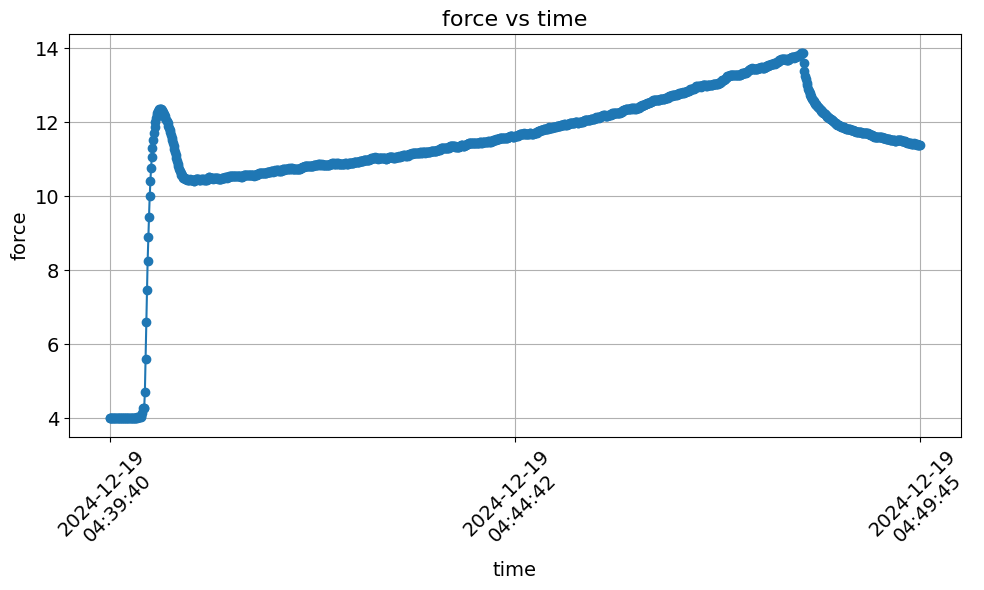

In [315]:
import pandas as pd
import matplotlib.pyplot as plt


def set_plot_style(ax, font_size, xlabel, ylabel):
    ax.set_xlabel(xlabel, fontsize=font_size)
    ax.set_ylabel(ylabel, fontsize=font_size)
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.grid(True)

def plot_measured_data(file_path, file_name, y_column):
    try:
        full_path = f"{file_path}/{file_name}"
        df = pd.read_csv(full_path)
        
        if 'time' not in df.columns:
            raise ValueError("The file must contain a 'time' column.")
        if y_column not in df.columns:
            raise ValueError(f"The specified y_column '{y_column}' is not in the data.")
        
        df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
        df.dropna(subset=['time'], inplace=True)

        x_time = df['time']
        y_values = df[y_column]

        fig, ax = plt.subplots(figsize=(10, 6))
        plt.plot(x_time, y_values, marker='o')
        set_plot_style(ax, 14, 'time', y_column)
        ax.set_title(f"{y_column} vs time", fontsize=16)

        # Set x-axis ticks to only start, middle, and end time
        times = x_time.sort_values()
        start = times.iloc[0]
        end = times.iloc[-1]
        mid_idx = len(times) // 2
        mid = times.iloc[mid_idx]

        ax.set_xticks([start, mid, end])
        ax.set_xticklabels([
            start.strftime('%Y-%m-%d') + '\n' + start.strftime('%H:%M:%S'),
            mid.strftime('%Y-%m-%d') + '\n' + mid.strftime('%H:%M:%S'),
            end.strftime('%Y-%m-%d') + '\n' + end.strftime('%H:%M:%S')
        ], rotation=45)

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"File '{full_path}' not found. Please provide a valid file path and name.")
    except ValueError as e:
        print(e)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")



if __name__ == "__main__":
# Specify the file path and file name to read
    #file_path = r"C:\Users\checkout\Documents\Anjani\Redesigned_Plastics\Dec2024_BL172\TS600_Scripts"  # Example fixed path
    file_path_tensile = r"/Users/akmaurya/OneDrive - Stanford/Data_01/Redesigned_Plastics/Dec_2024/Anjani/Redesigned_Plastics/Dec2024_BL172/TS600_Scripts"  # Example fixed path
    file_name = "insitu_Run2_LDPE_5mmmin_01.csv"
    #file_name = "insitu_Run6_PHPD_Film_base_5mmmin_01.csv"
    file_name = "insitu_Run8_PHPD_Film_base_3mmmin_01.csv"

    #file_name = "insitu_Run9_PHPD_MBfilm_3mmmin_01.csv"
    #file_name = 'insitu_Run10_P5HV_film_3mmmin_01.csv'

    #file_name = "insitu_Run15_P5HV_film_3mmmin_01.csv"

    #file_name = "insitu_Run16_LDPE_film_3mmmin_01.csv"
    #file_name = 'insitu_Run17_P5HV_film_5mmmin_01.csv'
   
    plot_measured_data(file_path_tensile, file_name, y_column="force")

## input crytallinity and peak position determination

## LDPE

Found 1 files for keyword 'insitu_Run2_LDPE_5mmmin_01'
Analyzing: subtracted_insitu_Run2_LDPE_5mmmin_01_Scan00001_azimuthal_data.h5 Opened file: /Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/subtracted_insitu_Run2_LDPE_5mmmin_01_Scan00001_azimuthal_data.h5
Top-level groups: ['data_0', 'data_1', 'data_10', 'data_100', 'data_101', 'data_102', 'data_103', 'data_104', 'data_105', 'data_106', 'data_107', 'data_108', 'data_109', 'data_11', 'data_110', 'data_111', 'data_112', 'data_113', 'data_114', 'data_115', 'data_116', 'data_117', 'data_118', 'data_119', 'data_12', 'data_120', 'data_121', 'data_122', 'data_123', 'data_124', 'data_125', 'data_126', 'data_127', 'data_128', 'data_129', 'data_13', 'data_130', 'data_131', 'data_132', 'data_133', 'data_134', 'data_135', 'data_136', 'data_137', 'data_138', 'data_139', 'data_14', 'data_140', 'data_141', 'data_142', 'data_143', 'data_144', 'data_145', 'data_146', 'data_147', 'data_148', 'data_149

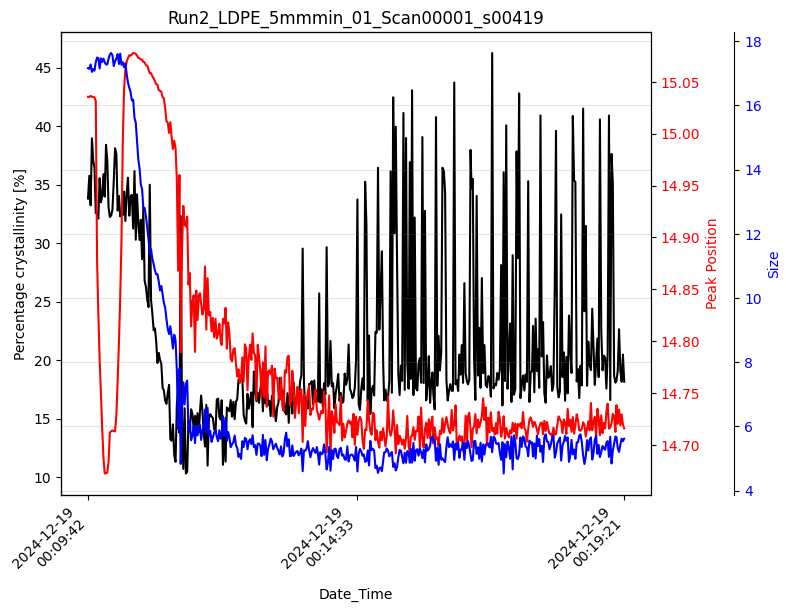

Data saved to: /Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/Final_analysis/crystallinity_Run2_LDPE_5mmmin_01_Scan00001_s00419.xlsx
Found 1 files for keyword 'insitu_Run16_LDPE_film_3mmmin_01'
Analyzing: subtracted_insitu_Run16_LDPE_film_3mmmin_01_Scan00001_azimuthal_data.h5 Opened file: /Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/subtracted_insitu_Run16_LDPE_film_3mmmin_01_Scan00001_azimuthal_data.h5
Top-level groups: ['data_0', 'data_1', 'data_10', 'data_100', 'data_101', 'data_102', 'data_103', 'data_104', 'data_105', 'data_106', 'data_107', 'data_108', 'data_109', 'data_11', 'data_110', 'data_111', 'data_112', 'data_113', 'data_114', 'data_115', 'data_116', 'data_117', 'data_118', 'data_119', 'data_12', 'data_120', 'data_121', 'data_122', 'data_123', 'data_124', 'data_125', 'data_126', 'data_127', 'data_128', 'data_129', 'data_13', 'data_130', 'data_131', 'data_132', 'data_133'

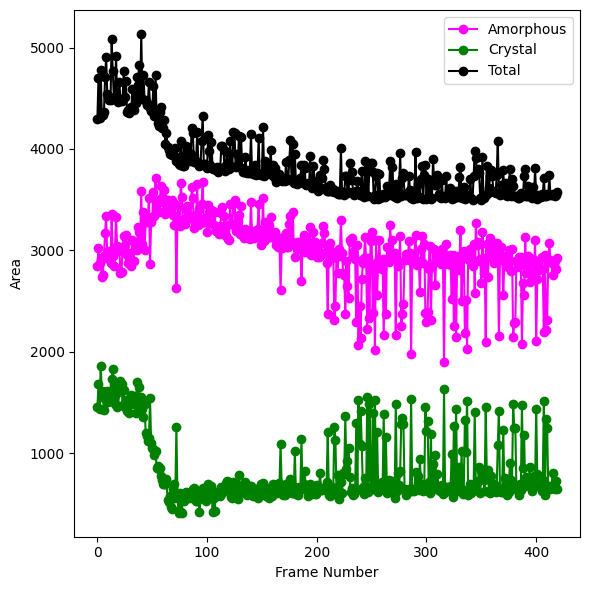

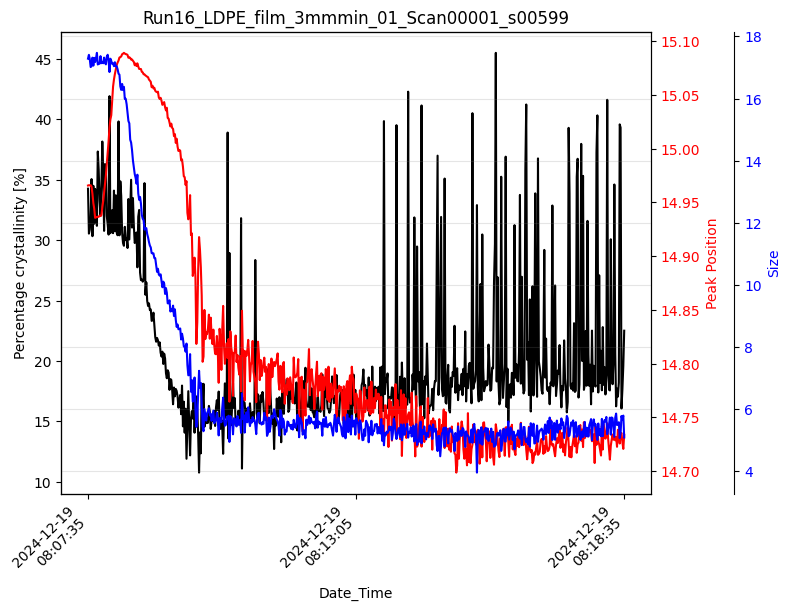

Data saved to: /Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/Final_analysis/crystallinity_Run16_LDPE_film_3mmmin_01_Scan00001_s00599.xlsx


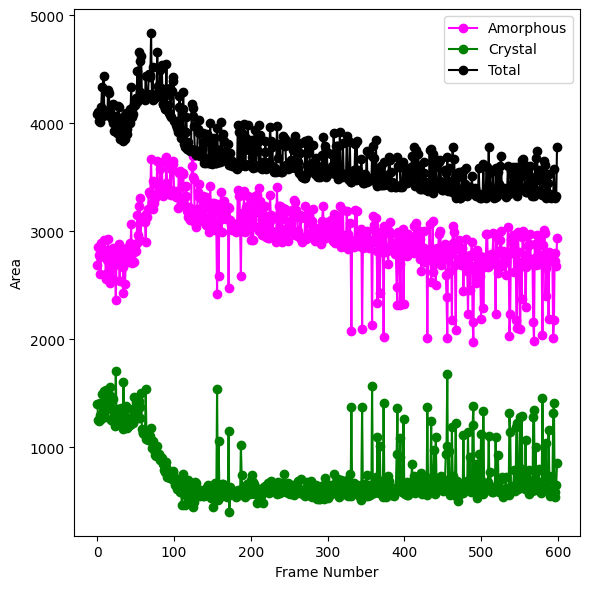

In [331]:
base_path = '/Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data'

samples_interpolation_flags = {
    'insitu_Run2_LDPE_5mmmin_01': False,
    'insitu_Run16_LDPE_film_3mmmin_01': False,
}

# Extract list of keywords and list of corresponding interpolation flags
keywords = list(samples_interpolation_flags.keys())
interpolation_flags = list(samples_interpolation_flags.values())


base_path=base_path
keywords=keywords                 # List of all sample names
interpolate_gap=interpolation_flags  # List of all flags in the same order
is_radial=False
min_q_value=7
max_q_value=20
min_q_peak=14
max_q_peak=15.7
lam=300
porder=2
itermax=100
fonts=20
dark_factor=0.8
q_mask_range=(8, 9.4)
smooth_window_size=1
min_chi=30
max_chi=135
chi_mask_range=(83, 88)
detrand=False
plot_data=False



for keyword, interp_flag in zip(keywords, interpolate_gap):
    pattern = os.path.join(base_path, f'*{keyword}*{"radial" if is_radial else "azimuthal"}*.h5')
    matched_files = glob.glob(pattern)
    print(f"Found {len(matched_files)} files for keyword '{keyword}'")

    for file_path in matched_files:
        print(f"Analyzing: {os.path.basename(file_path)}", end=' ')
        
        percentage_crytallinity, Per_cryst_error, peak_position_lorentzian_list, fwhm_lorentzian_list, size, d_spacing, date_time = analysis_hdf5_data(
            file_path,
            is_radial,
            min_q_value,
            max_q_value,
            min_q_peak,
            max_q_peak,
            lam,
            porder,
            itermax,
            fonts,
            dark_factor,
            q_mask_range=q_mask_range,
            smooth_window_size=smooth_window_size,
            min_chi=min_chi,
            max_chi=max_chi,
            chi_mask_range=chi_mask_range,
            detrand=detrand,
            interpolate_gap=interp_flag,  # <--- use the per-keyword flag
            plot_data=plot_data
        )


## PHPD

[False, False, False]
Found 1 files for keyword 'insitu_Run6_PHPD_film_base_5mmmin_01'
Analyzing: subtracted_insitu_Run6_PHPD_film_base_5mmmin_01_azimuthal_data.h5 Opened file: /Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/subtracted_insitu_Run6_PHPD_film_base_5mmmin_01_azimuthal_data.h5
Top-level groups: ['data_0', 'data_1', 'data_10', 'data_100', 'data_101', 'data_102', 'data_103', 'data_104', 'data_105', 'data_106', 'data_107', 'data_108', 'data_109', 'data_11', 'data_110', 'data_111', 'data_112', 'data_113', 'data_114', 'data_115', 'data_116', 'data_117', 'data_118', 'data_119', 'data_12', 'data_120', 'data_121', 'data_122', 'data_123', 'data_124', 'data_125', 'data_126', 'data_127', 'data_128', 'data_129', 'data_13', 'data_130', 'data_131', 'data_132', 'data_133', 'data_134', 'data_135', 'data_136', 'data_137', 'data_138', 'data_139', 'data_14', 'data_140', 'data_141', 'data_142', 'data_143', 'data_144', 'data_145', 'data_146', '

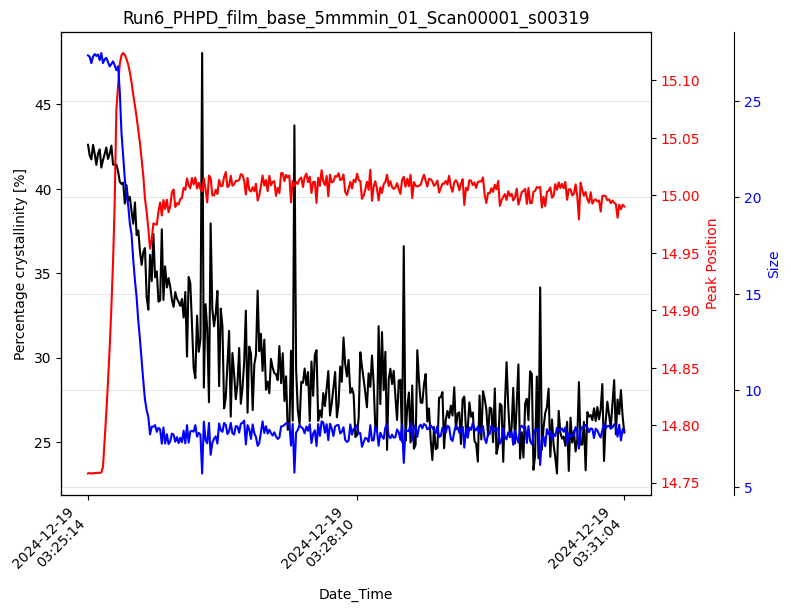

Data saved to: /Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/Final_analysis/crystallinity_Run6_PHPD_film_base_5mmmin_01_Scan00001_s00319.xlsx
Found 1 files for keyword 'insitu_Run8_PHPD_film_base_3mmmin_01'
Analyzing: subtracted_insitu_Run8_PHPD_film_base_3mmmin_01_azimuthal_data.h5 Opened file: /Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/subtracted_insitu_Run8_PHPD_film_base_3mmmin_01_azimuthal_data.h5
Top-level groups: ['data_0', 'data_1', 'data_10', 'data_100', 'data_101', 'data_102', 'data_103', 'data_104', 'data_105', 'data_106', 'data_107', 'data_108', 'data_109', 'data_11', 'data_110', 'data_111', 'data_112', 'data_113', 'data_114', 'data_115', 'data_116', 'data_117', 'data_118', 'data_119', 'data_12', 'data_120', 'data_121', 'data_122', 'data_123', 'data_124', 'data_125', 'data_126', 'data_127', 'data_128', 'data_129', 'data_13', 'data_130', 'data_131', 'data_132', 'data_13

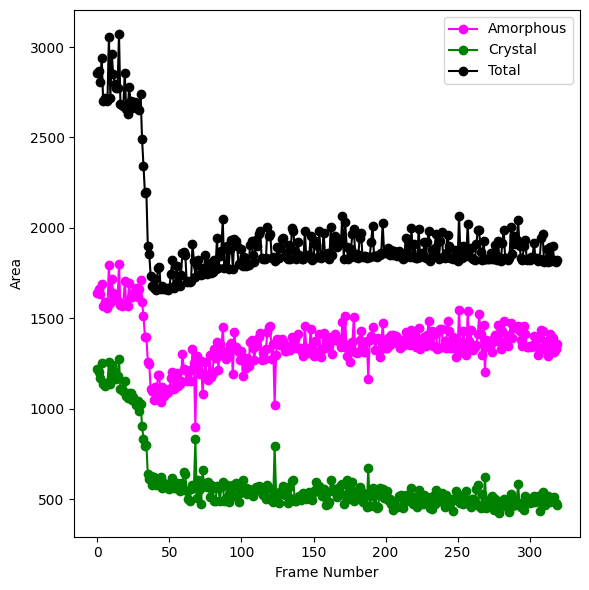

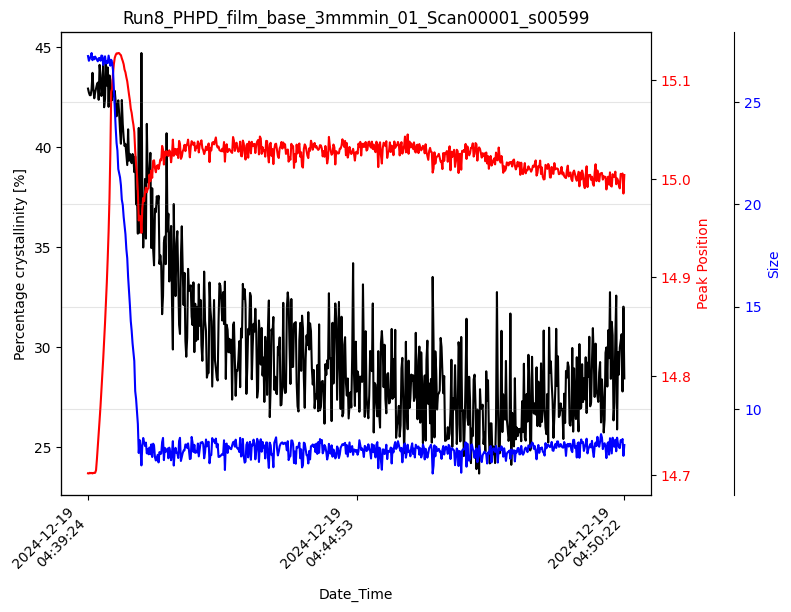

Data saved to: /Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/Final_analysis/crystallinity_Run8_PHPD_film_base_3mmmin_01_Scan00001_s00599.xlsx
Found 1 files for keyword 'insitu_Run9_PHPD_MBfilm_3mmmin_01'
Analyzing: subtracted_insitu_Run9_PHPD_MBfilm_3mmmin_01_azimuthal_data.h5 Opened file: /Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/subtracted_insitu_Run9_PHPD_MBfilm_3mmmin_01_azimuthal_data.h5
Top-level groups: ['data_0', 'data_1', 'data_10', 'data_100', 'data_101', 'data_102', 'data_103', 'data_104', 'data_105', 'data_106', 'data_107', 'data_108', 'data_109', 'data_11', 'data_110', 'data_111', 'data_112', 'data_113', 'data_114', 'data_115', 'data_116', 'data_117', 'data_118', 'data_119', 'data_12', 'data_120', 'data_121', 'data_122', 'data_123', 'data_124', 'data_125', 'data_126', 'data_127', 'data_128', 'data_129', 'data_13', 'data_130', 'data_131', 'data_132', 'data_133', 'data

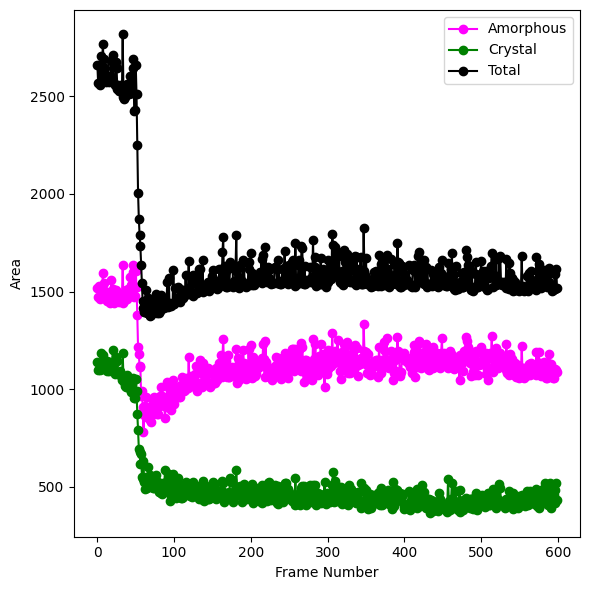

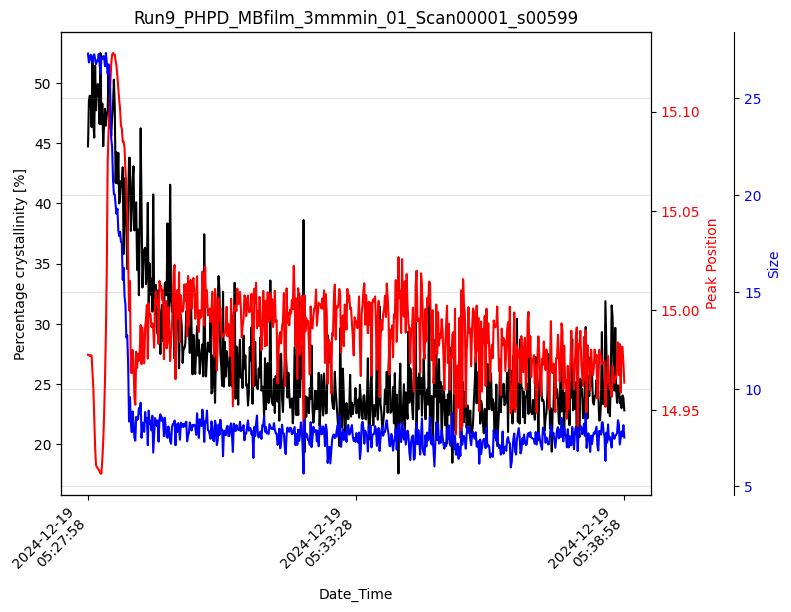

Data saved to: /Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/Final_analysis/crystallinity_Run9_PHPD_MBfilm_3mmmin_01_Scan00001_s00599.xlsx


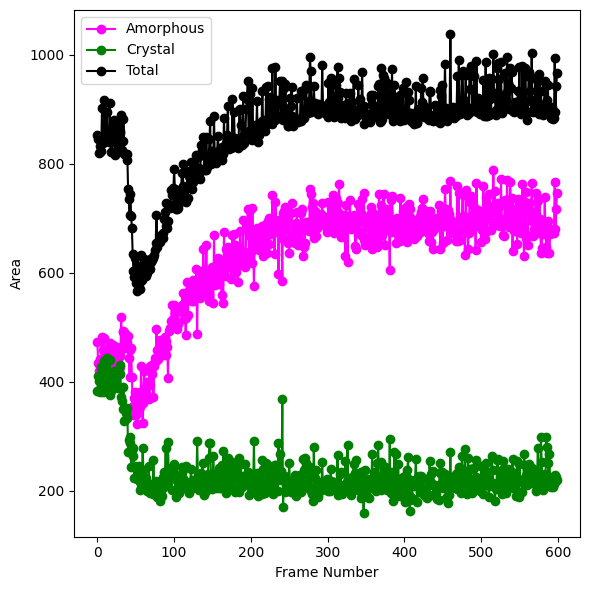

In [321]:
base_path = '/Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data'

samples_interpolation_flags = {
    'insitu_Run6_PHPD_film_base_5mmmin_01': False,
    'insitu_Run8_PHPD_film_base_3mmmin_01': False,
     'insitu_Run9_PHPD_MBfilm_3mmmin_01': False,
}


# Extract list of keywords and list of corresponding interpolation flags
keywords = list(samples_interpolation_flags.keys())
interpolation_flags = list(samples_interpolation_flags.values())

print(interpolation_flags)

base_path=base_path
keywords=keywords                 # List of all sample names
interpolate_gap=interpolation_flags  # List of all flags in the same order
is_radial=False
min_q_value=10
max_q_value=20
min_q_peak=14
max_q_peak=16
lam=300
porder=2
itermax=100
fonts=20
dark_factor=0.8
q_mask_range=(8, 9.4)
smooth_window_size=1
min_chi=30
max_chi=135
chi_mask_range=(83, 88)
detrand=False
plot_data=False
analysis_hdf5_data=analysis_hdf5_data  # Ensure this is defined before





for keyword, interp_flag in zip(keywords, interpolate_gap):
    pattern = os.path.join(base_path, f'*{keyword}*{"radial" if is_radial else "azimuthal"}*.h5')
    matched_files = glob.glob(pattern)
    print(f"Found {len(matched_files)} files for keyword '{keyword}'")

    for file_path in matched_files:
        print(f"Analyzing: {os.path.basename(file_path)}", end=' ')
        
        percentage_crytallinity, Per_cryst_error, peak_position_lorentzian_list, fwhm_lorentzian_list, size, d_spacing, date_time = analysis_hdf5_data(
            file_path,
            is_radial,
            min_q_value,
            max_q_value,
            min_q_peak,
            max_q_peak,
            lam,
            porder,
            itermax,
            fonts,
            dark_factor,
            q_mask_range=q_mask_range,
            smooth_window_size=smooth_window_size,
            min_chi=min_chi,
            max_chi=max_chi,
            chi_mask_range=chi_mask_range,
            detrand=detrand,
            interpolate_gap=interp_flag,  # <--- use the per-keyword flag
            plot_data=plot_data
        )



## P5HV

[False, False]
Found 1 files for keyword 'insitu_Run15_P5HV_film_3mmmin_01'
Analyzing: subtracted_insitu_Run15_P5HV_film_3mmmin_01_azimuthal_data.h5 Opened file: /Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/subtracted_insitu_Run15_P5HV_film_3mmmin_01_azimuthal_data.h5
Top-level groups: ['data_0', 'data_1', 'data_10', 'data_100', 'data_101', 'data_102', 'data_103', 'data_104', 'data_105', 'data_106', 'data_107', 'data_108', 'data_109', 'data_11', 'data_110', 'data_111', 'data_112', 'data_113', 'data_114', 'data_115', 'data_116', 'data_117', 'data_118', 'data_119', 'data_12', 'data_120', 'data_121', 'data_122', 'data_123', 'data_124', 'data_125', 'data_126', 'data_127', 'data_128', 'data_129', 'data_13', 'data_130', 'data_131', 'data_132', 'data_133', 'data_134', 'data_135', 'data_136', 'data_137', 'data_138', 'data_139', 'data_14', 'data_140', 'data_141', 'data_142', 'data_143', 'data_144', 'data_145', 'data_146', 'data_147', 'data_14

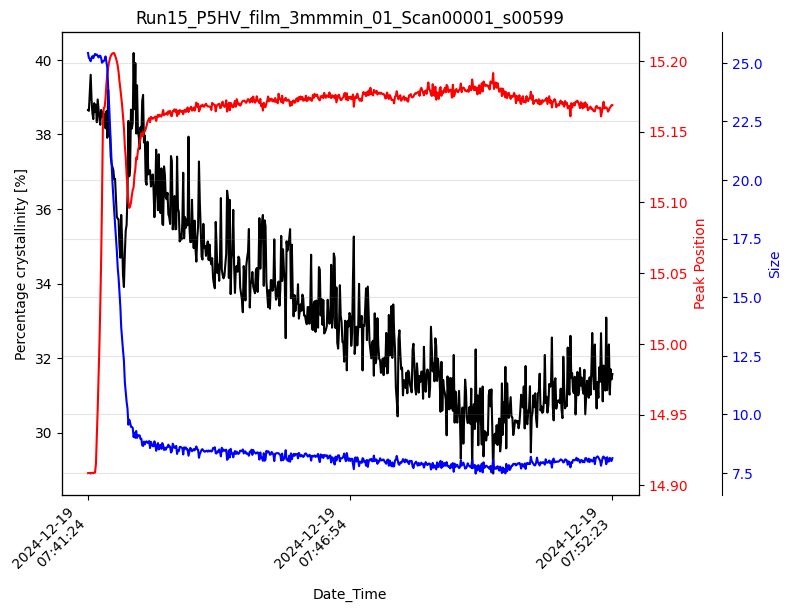

Data saved to: /Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/Final_analysis/crystallinity_Run15_P5HV_film_3mmmin_01_Scan00001_s00599.xlsx
Found 1 files for keyword 'insitu_Run17_P5HV_film_5mmmin_01'
Analyzing: subtracted_insitu_Run17_P5HV_film_5mmmin_01_azimuthal_data.h5 Opened file: /Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/subtracted_insitu_Run17_P5HV_film_5mmmin_01_azimuthal_data.h5
Top-level groups: ['data_0', 'data_1', 'data_10', 'data_100', 'data_101', 'data_102', 'data_103', 'data_104', 'data_105', 'data_106', 'data_107', 'data_108', 'data_109', 'data_11', 'data_110', 'data_111', 'data_112', 'data_113', 'data_114', 'data_115', 'data_116', 'data_117', 'data_118', 'data_119', 'data_12', 'data_120', 'data_121', 'data_122', 'data_123', 'data_124', 'data_125', 'data_126', 'data_127', 'data_128', 'data_129', 'data_13', 'data_130', 'data_131', 'data_132', 'data_133', 'data_134', 

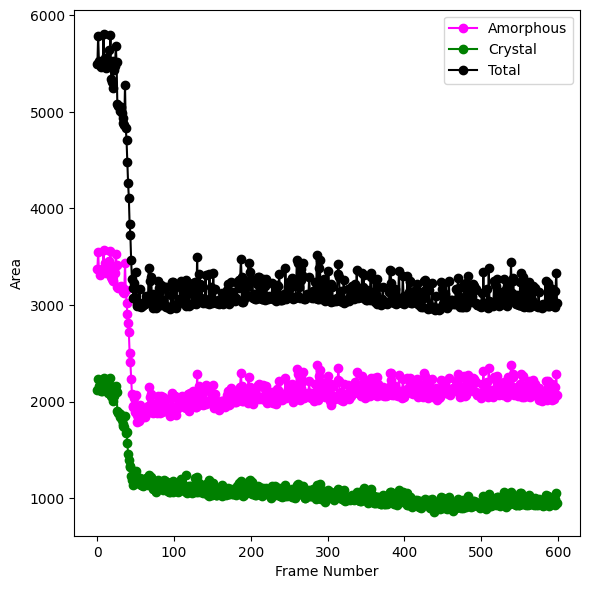

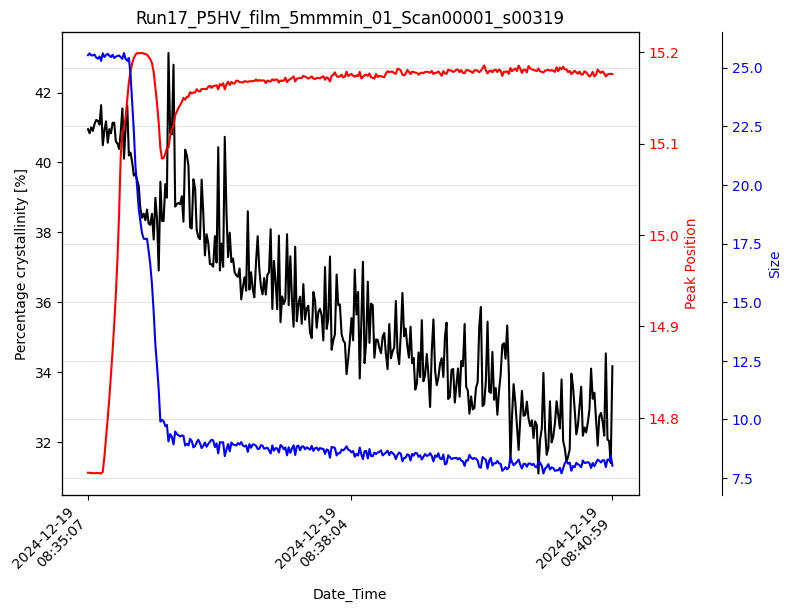

Data saved to: /Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/Final_analysis/crystallinity_Run17_P5HV_film_5mmmin_01_Scan00001_s00319.xlsx


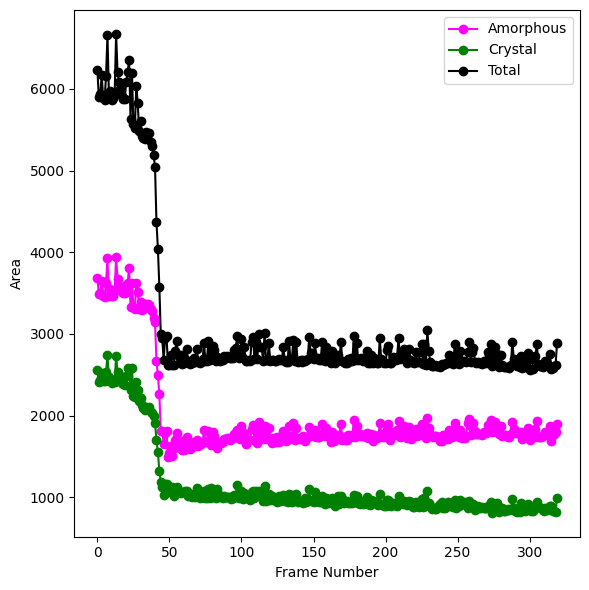

In [322]:
base_path = '/Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data'

samples_interpolation_flags = {
    #'insitu_Run10_P5HV_film_3mmmin_01': False,
    #'insitu_Run14_P5HV_film_3mmmin_01': False,
     'insitu_Run15_P5HV_film_3mmmin_01': False,
     'insitu_Run17_P5HV_film_5mmmin_01': False,
}



# Extract list of keywords and list of corresponding interpolation flags
keywords = list(samples_interpolation_flags.keys())
interpolation_flags = list(samples_interpolation_flags.values())

print(interpolation_flags)


base_path=base_path
keywords=keywords                # List of all sample names
interpolate_gap=interpolation_flags  # List of all flags in the same order
is_radial=False
min_q_value=12
max_q_value=20
min_q_peak=14
max_q_peak=16
lam=300
porder=2
itermax=100
fonts=20
dark_factor=0.8
q_mask_range=(8, 9.4)
smooth_window_size=1
min_chi=30
max_chi=135
chi_mask_range=(83, 88)
detrand=False
plot_data=False
analysis_hdf5_data=analysis_hdf5_data  # Ensure this is defined before





for keyword, interp_flag in zip(keywords, interpolate_gap):
    pattern = os.path.join(base_path, f'*{keyword}*{"radial" if is_radial else "azimuthal"}*.h5')
    matched_files = glob.glob(pattern)
    print(f"Found {len(matched_files)} files for keyword '{keyword}'")

    for file_path in matched_files:
        print(f"Analyzing: {os.path.basename(file_path)}", end=' ')
        
        percentage_crytallinity, Per_cryst_error, peak_position_lorentzian_list, fwhm_lorentzian_list, size, d_spacing, date_time = analysis_hdf5_data(
            file_path,
            is_radial,
            min_q_value,
            max_q_value,
            min_q_peak,
            max_q_peak,
            lam,
            porder,
            itermax,
            fonts,
            dark_factor,
            q_mask_range=q_mask_range,
            smooth_window_size=smooth_window_size,
            min_chi=min_chi,
            max_chi=max_chi,
            chi_mask_range=chi_mask_range,
            detrand=detrand,
            interpolate_gap=interp_flag,  # <--- use the per-keyword flag
            plot_data=plot_data
        )




# Determine orientation


## Function 1: determine Orintation

In [309]:
import numpy as np
import scipy.optimize as opt
import scipy.signal as signal
import matplotlib.pyplot as plt

# Lorentzian function definition
def lorentzian(x, A, x0, gamma):
    return A / (1 + ((x - x0) / gamma)**2)

# Gaussian function definition
def gaussian(x, A, x0, sigma):
    return A * np.exp(-((x - x0)**2) / (2 * sigma**2))

# Pseudo-Voigt function definition
def pseudo_voigt(x, A, x0, sigma, gamma, eta):
    return eta * lorentzian(x, A, x0, gamma) + (1 - eta) * gaussian(x, A, x0, sigma)

# Function to calculate FWHM for each type of fit
def calculate_fwhm(fit_type, params):
    if fit_type == 'lorentzian':
        # FWHM = 2 * gamma
        return 2 * params[2]
    elif fit_type == 'gaussian':
        # FWHM = 2 * sqrt(2 * ln(2)) * sigma
        return 2.35482 * params[2]
    elif fit_type == 'pseudo_voigt':
        # Estimate FWHM for Pseudo-Voigt
        sigma = params[2]
        gamma = params[3]
        eta = params[4]
        return eta * (2 * gamma) + (1 - eta) * (2.35482 * sigma)

import numpy as np
import scipy.optimize as opt
import scipy.signal as signal
from scipy.special import wofz

# Define peak shape functions
def gaussian(x, A, x0, sigma):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2))

def lorentzian(x, A, x0, gamma):
    return A * (gamma**2 / ((x - x0)**2 + gamma**2))

def pseudo_voigt(x, A, x0, sigma, gamma, eta):
    G = gaussian(x, 1, x0, sigma)
    L = lorentzian(x, 1, x0, gamma)
    return A * (eta * L + (1 - eta) * G)

def voigt(x, A, x0, sigma, gamma):
    """ Voigt profile using scipy's wofz (Faddeeva function). """
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

# Function to calculate FWHM
def calculate_fwhm(fit_type, popt):
    if fit_type == 'gaussian':
        return 2 * np.sqrt(2 * np.log(2)) * popt[2]  # 2*sqrt(2ln2)*sigma
    elif fit_type == 'lorentzian':
        return 2 * popt[2]  # 2*gamma
    elif fit_type == 'pseudo_voigt':
        return 0.5346 * 2 * popt[3] + np.sqrt(0.2166 * (2 * popt[3])**2 + (2.3548 * popt[2])**2)
    elif fit_type == 'voigt':
        # Approximate Voigt FWHM
        gamma_G = popt[2] * np.sqrt(2*np.log(2))
        gamma_L = 2 * popt[3]
        return 0.5346 * gamma_L + np.sqrt(0.2166 * gamma_L**2 + gamma_G**2)
    else:
        return np.nan

import numpy as np
import scipy.optimize as opt
import scipy.signal as signal
import matplotlib.pyplot as plt

# Example peak functions
def lorentzian(x, A, x0, gamma):
    return A * gamma**2 / ((x - x0)**2 + gamma**2)

def gaussian(x, A, x0, sigma):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2))

def pseudo_voigt(x, A, x0, sigma, gamma, eta):
    return eta * lorentzian(x, A, x0, gamma) + (1 - eta) * gaussian(x, A, x0, sigma)

def voigt(x, A, x0, sigma, gamma):
    from scipy.special import wofz
    z = ((x - x0) + 1j*gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

# Function to calculate FWHM based on fit parameters
def calculate_fwhm(fit_type, popt):
    if fit_type == 'lorentzian':
        return 2 * popt[2]  # 2*gamma
    elif fit_type == 'gaussian':
        return 2.355 * popt[2]  # 2.355*sigma
    elif fit_type == 'pseudo_voigt' or fit_type == 'voigt':
        # Approximate FWHM for Voigt
        sigma = popt[2]
        gamma = popt[3]
        return 0.5346 * 2*gamma + np.sqrt(0.2166*(2*gamma)**2 + (2.355*sigma)**2)
    else:
        return None

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, optimize as opt

# Main peak fitting function
def fit_peaks(x, y, fit_type='lorentzian', prominence=10, width=10, plot_fits=True):
    # Find peaks
    peaks, properties = signal.find_peaks(y, prominence=prominence, width=width)

    fit_params = []
    fwhm_list = []
    peak_positions = []
    y_fitted = np.zeros_like(y)

    for peak in peaks:
        # Define fitting window around peak
        left = max(0, peak - 10)
        right = min(len(x), peak + 10)

        x_peak = x[left:right]
        y_peak = y[left:right]

        if len(x_peak) < 3:
            continue  # Skip too-small ranges to avoid curve_fit failure

        # Estimate peak width
        width_est_px = properties['widths'][np.where(peaks == peak)[0][0]]
        width_est = width_est_px * (x[1] - x[0])

        # Define dynamic boundaries based on x_peak range
        x_min, x_max = np.min(x_peak), np.max(x_peak)

        # Smart initial guesses and fit bounds
        if fit_type == 'lorentzian':
            p0 = [y[peak], x[peak], width_est / 2]
            func = lorentzian
            bounds = ([-np.inf, x_min, 0], [np.inf, x_max, np.inf])

        elif fit_type == 'gaussian':
            p0 = [y[peak], x[peak], width_est / 2.355]
            func = gaussian
            bounds = ([-np.inf, x_min, 0], [np.inf, x_max, np.inf])

        elif fit_type == 'pseudo_voigt':
            p0 = [y[peak], x[peak], width_est / 2.355, width_est / 2, 0.5]
            func = pseudo_voigt
            bounds = ([-np.inf, x_min, 0, 0, 0], [np.inf, x_max, np.inf, np.inf, 1])

        elif fit_type == 'voigt':
            p0 = [y[peak], x[peak], width_est / 2.355, width_est / 2]
            func = voigt
            bounds = ([-np.inf, x_min, 0, 0], [np.inf, x_max, np.inf, np.inf])

        else:
            raise ValueError("fit_type must be 'lorentzian', 'gaussian', 'pseudo_voigt', or 'voigt'")

        # Perform curve fitting
        try:
            popt, _ = opt.curve_fit(func, x_peak, y_peak, p0=p0, bounds=bounds, maxfev=10000)
            fit_params.append(popt)

            # Add to total fitted curve
            y_fitted += func(x, *popt)

            # Store FWHM and peak position
            fwhm = calculate_fwhm(fit_type, popt)
            fwhm_list.append(fwhm)
            peak_positions.append(popt[1])

        except RuntimeError:
            print(f"Could not fit peak at x = {x[peak]}")

    # Optional plotting
    if plot_fits:
        plt.figure(figsize=(8, 5))
        plt.plot(x, y, label='Original Data', color='black')
        plt.plot(x, y_fitted, label=f'{fit_type.capitalize()} Fit', linestyle='--', color='red')
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('Intensity')
        plt.title('Peak Fitting')
        plt.show()

    return fit_params, y_fitted, fwhm_list, peak_positions


## pchi orinetation


In [310]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

def remove_and_interpolate_q_range_pchip(q, I, qmin, qmax, label=None, show_plot=True):
    mask_remove = (q >= qmin) & (q <= qmax)
    mask_keep = ~mask_remove

    q_known = q[mask_keep]
    I_known = I[mask_keep]

    # Remove non-finite values
    finite_mask = np.isfinite(I_known)
    q_known = q_known[finite_mask]
    I_known = I_known[finite_mask]

    if len(q_known) < 2:
        raise ValueError("Not enough finite points to perform interpolation.")

    # Interpolate
    interpolator = PchipInterpolator(q_known, I_known)
    I_interp = interpolator(q)

    # Store original data for plotting
    I_original = I.copy()

    # Replace removed region with interpolated values
    I[mask_remove] = I_interp[mask_remove]

    if show_plot:
        plt.figure(figsize=(6, 4))
        plt.plot(q, I_original, 'o',markersize =1, label='Original', alpha=0.5, linestyle='--')
        plt.plot(q, I, label='Interpolated', linewidth=2)
        plt.axvspan(qmin, qmax, color='gray', alpha=0.2, label='Interpolated Region')
        if label:
            plt.title(f'Interpolation: {label}')
        plt.xlabel('q or χ')
        plt.ylabel('Intensity')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return q, I


## Remove only

In [311]:
import numpy as np
import matplotlib.pyplot as plt

def remove_q_range_only(q, I, qmin, qmax, label=None, show_plot=True):
    # Mask to keep only data outside the q range
    mask_keep = (q < qmin) | (q > qmax)

    q_filtered = q[mask_keep]
    I_filtered = I[mask_keep]

    if show_plot:
        plt.figure(figsize=(6, 4))
        plt.plot(q, I, label='Original', alpha=0.5, linestyle='--')
        plt.plot(q_filtered, I_filtered, label='After Removal', linewidth=2)
        plt.axvspan(qmin, qmax, color='gray', alpha=0.2, label='Removed Region')
        if label:
            plt.title(f'Removal Only: {label}')
        plt.xlabel('q or χ')
        plt.ylabel('Intensity')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return q_filtered, I_filtered


## Function 2: determine Orintation     

In [312]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import h5py
import pandas as pd
from datetime import date, time

# Add or define the following functions separately:
# - extract_data_from_hdf5_general
# - smooth_data
# - remove_and_interpolate_q_range_pchip
# - airpls
# - fit_radial_peak
# - set_plot_style

def analysis_radial_profile_data(
        file_path, is_radial=True, min_q_value=10, max_q_value=25,
        min_q_peak=14, max_q_peak=16.5, lam=500000, porder=3, itermax=100, fonts=20,
        dark_factor=0.8, min_chi=-180, max_chi=180,smooth_window_size=1,
        chi_mask1=(83, 88), chi_mask2=(83, 88), chi_mask3=(83, 88), plot_data=True):
    
    cmap_original = plt.colormaps['RdYlGn_r']
    cmap_colors = cmap_original(np.arange(cmap_original.N))
    cmap_colors[:, :3] *= dark_factor
    cmap_dark = ListedColormap(cmap_colors)

    all_fwhm_list = []
    all_peak_positions = []

    data = extract_data_from_hdf5_general(file_path, is_radial=True)
    data_sorted = sorted(data, key=lambda x: x[-1])

    save_folder = os.path.join(os.path.dirname(file_path), 'Final_analysis')
    os.makedirs(save_folder, exist_ok=True)

    for entry in data_sorted:
        if is_radial:
            chi, I, err, filename, real_date_time, i0, i1, Photod, snumber = entry
            #I = smooth_data(I, smooth_window_size)
            I = smooth_data(I, smooth_window_size)
            
            for chi_mask in [chi_mask1, chi_mask2, chi_mask3]:
                chi, I = remove_and_interpolate_q_range_pchip(chi, I, *chi_mask)

            # Shift chi from (-180, 180) to (0, 360)
            #chi = chi + 180

            mask1 = (chi >= min_chi) & (chi <= max_chi)
            x_mask = chi[mask1]
            y_mask_with_base = I[mask1]


            I_base = airpls(y_mask_with_base, 10000000000000, 2, 100)

            I_base = I_base - + 0.01*np.min(y_mask_with_base)
            y_mask_base = (y_mask_with_base - 1*I_base) #

            y_mask = y_mask_base

            #y = 1000* y_mask/np.sum(y_mask)
            y = y_mask
            x = x_mask

            I_detrend = airpls(y, lam=lam, porder=porder, itermax=itermax)
            y = y - 1*I_detrend



            #for chi_mask in [chi_mask1, chi_mask2, chi_mask3]:
            #x_gap, y_gap = remove_q_range_only(x, y, *chi_mask)

            x_gap, y_gap = remove_q_range_only(x, y, chi_mask2[0],chi_mask2[1])

            # Peak fitting
            x_gap = x_gap + 180
            x = x +180
            mask_fit = (x_gap >= 150) & (x_gap <= 200)
            x_to_fit = x_gap[mask_fit]
            y_to_fit = y_gap[mask_fit]




            #df = pd.DataFrame({'chi': x, 'I_detrand': y + I_detrend})
            #filename_no_ext = os.path.splitext(filename)[0]
            #df.to_excel(os.path.join(save_folder, f'{filename_no_ext}_radial.xlsx'), index=False)



            print(len(x_to_fit),len(y_to_fit))

            # Peak fitting for radial data
            peak_positions, fwhm_list, y_fitted, model_func, popt = fit_radial_peak(x_to_fit, y_to_fit, 'gaussian')  #lorentzian

            #df = pd.DataFrame({'chi': x_gap, 'I_detrend': y_gap})
            #filename_no_ext = os.path.splitext(filename)[0]
            #df.to_excel(os.path.join(save_folder, f'{filename_no_ext}_radial.xlsx'), index=False)

            yfit = model_func(x,*popt)

            df = pd.DataFrame({'chi': x_mask, 'I_detrand': y_mask, 'y_fit': yfit })
            filename_no_ext = os.path.splitext(filename)[0]
            df.to_excel(os.path.join(save_folder, f'{filename_no_ext}_radial.xlsx'), index=False)
            

            # Ensure peak_positions and fwhm_list are lists
            if not isinstance(peak_positions, (list, np.ndarray)):
                peak_positions = [peak_positions]
            if not isinstance(fwhm_list, (list, np.ndarray)):
                fwhm_list = [fwhm_list]

            all_fwhm_list.append(fwhm_list)
            all_peak_positions.append(peak_positions)

            if plot_data:
                fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

                # First subplot: show the raw data with background and baseline
                axs[0].plot(x, y_mask_with_base, 'o', color='yellow', label='data_with_bkg')
                axs[0].plot(x, I_base, '-', color='m', label='baseline')
                axs[0].set_title('Raw Data with Background')
                set_plot_style(axs[0], fonts, 'Chi [deg]', 'Intensity')
                axs[0].legend()

                # Second subplot: detrended data and fitted curve
                axs[1].plot(x, y + I_detrend, 'o', color='gray', label='Data')
                axs[1].plot(x, I_detrend, label='Amorphous', color='blue')
                axs[1].plot(x_gap, y_gap, 'ko', label='Peak')
                axs[1].plot(x_to_fit, y_to_fit, 'go')
                axs[1].plot(x, yfit, '-', color='red', label='Fitted Curve')

                for i, (peak, fwhm) in enumerate(zip(peak_positions, fwhm_list)):
                    axs[1].axvline(x=peak, color='m', linestyle='--', label=f'Peak: {peak:.2f}\nFWHM: {fwhm:.2f}')
                    axs[1].fill_betweenx([0, np.max(y)], peak - fwhm / 2, peak + fwhm / 2, color='gray', alpha=0.5)

                axs[1].set_title('Detrended Data with Peaks and Fitting')
                set_plot_style(axs[1], fonts, 'Chi [deg]', 'Intensity')
                axs[1].legend()

                plt.tight_layout()
                plt.show()


    # Summary plots for Peak 1 only
    peak1_list = []
    fwhm1_list = []

    for peaks, fwhms in zip(all_peak_positions, all_fwhm_list):
        peak1_list.append(peaks[0] if len(peaks) > 0 else np.nan)
        fwhm1_list.append(fwhms[0] if len(fwhms) > 0 else np.nan)

    fig, ax1 = plt.subplots()
    ax1.plot(peak1_list, 'ro-', label='Peak Position')
    ax1.set_xlabel('Frame Number')
    ax1.set_ylabel('Peak Position', color='red')
    ax1.tick_params(axis='y', labelcolor='red')

    ax2 = ax1.twinx()
    ax2.plot(fwhm1_list, 'mo--', label='FWHM')
    ax2.set_ylabel('FWHM', color='magenta')
    ax2.tick_params(axis='y', labelcolor='magenta')

    plt.tight_layout()
    plt.show()

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Return the lists at the end of the function
    return all_fwhm_list, all_peak_positions


## Plot Orientation parameters


In [313]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def analyze_radial_data(
    base_path, 
    keywords,
    analysis_radial_profile_data,
    is_radial=True,
    min_q_value=10,
    max_q_value=14,
    min_q_peak=11,
    max_q_peak=11.9,
    lam=50000,
    porder=2,
    itermax=100,
    fonts=18,
    dark_factor=0.8,
    q_mask_range=(20, 20.5),
    smooth_window_size=1,
    min_chi=-180,
    max_chi=0,
    chi_mask1=(-140, -125),
    chi_mask2=(-80, -70),
    chi_mask3=(-55, -40),
    detrand=False,
    plot_data=True
):
    results = defaultdict(lambda: defaultdict(list))

    for keyword in keywords:
        pattern = os.path.join(base_path, f'*{keyword}*{"radial" if is_radial else "azimuthal"}*.h5')
        matched_files = glob.glob(pattern)
        print(f"Found {len(matched_files)} files for keyword '{keyword}'")

        for file_path in matched_files:
            print(f"Analyzing: {os.path.basename(file_path)}", end=' ')
            
            all_fwhm_list, all_peak_positions = analysis_radial_profile_data(
                file_path=file_path,
                min_q_value=min_q_value,
                max_q_value=max_q_value,
                min_q_peak=min_q_peak,
                max_q_peak=max_q_peak,
                lam=lam,
                porder=porder,
                itermax=itermax,
                fonts=fonts,
                dark_factor=dark_factor,
                smooth_window_size=smooth_window_size,
                min_chi=min_chi,
                max_chi=max_chi,
                chi_mask1=chi_mask1,
                chi_mask2=chi_mask2,
                chi_mask3=chi_mask3,
                plot_data=plot_data
            )

            all_fwhm_list = np.concatenate([np.atleast_1d(fwhm) for fwhm in all_fwhm_list])
            print(all_fwhm_list)
            all_peak_positions = np.concatenate([np.atleast_1d(peak_pos) for peak_pos in all_peak_positions])
            print(all_peak_positions)

            # Compute per-file means, standard deviations, and store only those
            mean_fwhm = np.mean(all_fwhm_list)
            std_fwhm = np.std(all_fwhm_list)
            mean_peak = np.mean(all_peak_positions)
            std_peak = np.std(all_peak_positions)

            results[keyword]["fwhm"].append((mean_fwhm, std_fwhm))
            results[keyword]["peak_position"].append((mean_peak, std_peak))

    # Generate summary statistics from per-file means and standard deviations
    summary = defaultdict(dict)
    for keyword in keywords:
        for key in ['fwhm', 'peak_position']:
            data = np.array(results[keyword][key])
            avg_val = np.mean(data[:, 0])
            std_val = np.mean(data[:, 1])
            summary[keyword][key + '_avg'] = avg_val
            summary[keyword][key + '_std'] = std_val

    # Prepare DataFrame for plotting
    params_to_plot = ['peak_position', 'fwhm']
    ylabels = {
        'peak_position': 'Peak Position [Degrees]',
        'fwhm': 'FWHM [Degrees]'
    }

    plot_data_list = []
    for param in params_to_plot:
        for keyword in keywords:
            mean_val = summary[keyword][param + '_avg']
            std_val = summary[keyword][param + '_std']
            
            print(f"{keyword} - {param}: Mean = {mean_val:.4f}, Error = {std_val:.4f}")
            
            plot_data_list.append({
                'Condition': keyword,
                'Parameter': param.replace('_', ' ').title(),
                'Value': mean_val,
                'Error': std_val
            })

    df_plot = pd.DataFrame(plot_data_list)

    # Plotting
    axis_color = 'black'
    label_fontsize = fonts
    title_fontsize = fonts + 2

    for keyword in keywords:
        keyword1 = keyword.split('_')[0]

    for param in df_plot['Parameter'].unique():
        subset = df_plot[df_plot['Parameter'] == param]
        x_positions = np.arange(len(subset))

        fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

        ax.errorbar(
            x_positions,
            subset['Value'],
            yerr=subset['Error'],
            fmt='o-',
            ecolor='black',
            elinewidth=1.5,
            capsize=6,
            capthick=1.5,
            markerfacecolor='white',
            markeredgewidth=2,
            markersize=8,
            color='black'
        )

        ax.set_title(param, fontsize=title_fontsize, color=axis_color)
        ax.set_xlabel('Condition', fontsize=label_fontsize, color=axis_color)
        ax.set_ylabel(ylabels[param.lower().replace(" ", "_")], fontsize=label_fontsize, color=axis_color)
        
        ax.set_xticks(x_positions)
        ax.set_xticklabels(subset['Condition'], rotation=30, ha='right', fontsize=label_fontsize - 2, color=axis_color)
        ax.tick_params(colors=axis_color, labelsize=label_fontsize - 2)

        # Optional custom plot styling
        try:
            set_plot_style(ax, label_fontsize, 'Processing Conditions', ylabels[param.lower().replace(" ", "_")])
        except NameError:
            pass  # If set_plot_style is not defined

        for spine in ax.spines.values():
            spine.set_color(axis_color)

        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

        plt.tight_layout()
        

        # Save the figure
        save_dir = os.path.join(base_path, 'Final_analysis')
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{keyword1}_{param.replace(" ", "_").lower()}_orientation_summary.png')
        plt.savefig(save_path, dpi=300)
        print(f"Saved plot to {save_path}")
        
        plt.show()

    # Save summary to Excel
    summary_df = pd.DataFrame(summary).T
    excel_path = os.path.join(base_path, 'Final_analysis', f'{keyword1}_orientation_summary.xlsx')
    summary_df.to_excel(excel_path, index=True)
    print(f"Saved summary to {excel_path}")

    return results, summary, df_plot


## LDPE

In [ ]:
base_path = '/Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data'



keywords = [
     
    #'insitu_Run2_LDPE_5mmmin_01_Scan00001',
    'insitu_Run16_LDPE_film_3mmmin_01_Scan00001',
]


base_path=base_path
keywords=keywords,
analysis_radial_profile_data=analysis_radial_profile_data  # Replace with your actual function
is_radial=True  # Set to False if you are working with azimuthal data
min_chi= -50 #-110,
max_chi= 14.5    #-70,
chi_mask1= (-150, -128)#(-145, -130),
chi_mask2=(-81, -72)
chi_mask3=(-55, -35)
lam=10000 
porder=2 
itermax=100
smooth_window_size=1
plot_data=True  # Set to False if you don't want plots



for keyword in keywords:
    pattern = os.path.join(base_path, f'*{keyword}*{"radial" if is_radial else "azimuthal"}*.h5')
    matched_files = glob.glob(pattern)
    print(f"Found {len(matched_files)} files for keyword '{keyword}'")

    for file_path in matched_files:
        print(f"Analyzing: {os.path.basename(file_path)}", end=' ')
        
        all_fwhm_list, all_peak_positions = analysis_radial_profile_data(
            file_path=file_path,
            min_q_value=min_q_value,
            max_q_value=max_q_value,
            min_q_peak=min_q_peak,
            max_q_peak=max_q_peak,
            lam=lam,
            porder=porder,
            itermax=itermax,
            fonts=fonts,
            dark_factor=dark_factor,
            smooth_window_size=smooth_window_size,
            min_chi=min_chi,
            max_chi=max_chi,
            chi_mask1=chi_mask1,
            chi_mask2=chi_mask2,
            chi_mask3=chi_mask3,
            plot_data=plot_data
        )

# Plot final data

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_excel_data_and_plot(folder_path, keywords, chi_mask2, mode='radial', xlim=(0, 20)):
    data_frames = []
    intensity_matrix = []
    x_axis_reference = None  # to ensure consistent x-axis across files

    if not os.path.exists(folder_path):
        print(f"Folder path '{folder_path}' does not exist.")
        return

    keywords = [kw.lower() for kw in keywords]
    mode = mode.lower()

    matched_files = []
    for filename in sorted(os.listdir(folder_path)):
        filename_lower = filename.lower()
        if filename_lower.endswith('.xlsx') and mode in filename_lower and any(kw in filename_lower for kw in keywords):
            if filename.startswith("._"):
                continue
            matched_files.append(filename)

    def keyword_order(filename):
        filename_lower = filename.lower()
        for i, kw in enumerate(keywords):
            if kw in filename_lower:
                return i
        return len(keywords)

    matched_files.sort(key=keyword_order)

    for filename in matched_files:
        print(f"Matching file: {filename}")
        file_path = os.path.join(folder_path, filename)
        df = pd.read_excel(file_path, engine='openpyxl')

        if mode == 'azimuthal':
            x_col = next((col for col in df.columns if col.lower().startswith('q')), None)
            x_label = 'q [nm⁻¹]'
        elif mode == 'radial':
            x_col = next((col for col in df.columns if col.lower().startswith('chi')), None)
            x_label = 'χ [°]'
        else:
            print(f"Unknown mode: {mode}")
            return

        i_col = next((col for col in df.columns if 'i' in col.lower() and 'detrand' in col.lower()), None)
        fit_col = df.columns[2] if len(df.columns) >= 3 else None

        if x_col and i_col:
            label = create_label(filename)
            subset_df = df[[x_col, i_col]] if not fit_col else df[[x_col, i_col, fit_col]]
            data_frames.append((subset_df.copy(), label))
        else:
            print(f"Skipping {filename} due to missing expected columns.")

    if not data_frames:
        print("No files matched the criteria.")
        return

    fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
    darkened_colors = darken_colors(len(data_frames), 0.8)

    for idx, (df, label) in enumerate(data_frames):
        x = df.iloc[:, 0]
        I = df.iloc[:, 1]
        has_fit = df.shape[1] == 3
        y_fit = df.iloc[:, 2] if has_fit else None

        if x_axis_reference is None:
            x_axis_reference = x

        if mode == 'azimuthal': 
            I = 1000 * I / np.sum(I)
        else:
            if len(I) > 0:
                q_min, q_max = chi_mask2[0], chi_mask2[1]
                mask = (x < q_min) | (x > q_max)
                x1, I1 = x[mask], I[mask]
                if has_fit:
                    y_fit = y_fit  # Optionally mask y_fit too

                peak_index = np.argmax(y_fit) if y_fit is not None else None
                if peak_index is not None:
                    peak_I = y_fit.iloc[peak_index]
                    if peak_I > 0.2:
                        peak_x = x1.iloc[peak_index]

        color = darkened_colors[idx]
        if mode == 'radial':
            ax.plot(x1, I1, '-', markersize=3, label=label, color=color)
            if has_fit:
                ax.plot(x, y_fit, '-', linewidth=1.5, color='grey', alpha=0.6)
        else:
            ax.plot(x, I, '-', markersize=3, label=label, color=color)

        intensity_matrix.append(I.values)

    ax.set_xlabel(x_label)
    ax.set_ylabel('Intensity [a.u.]')
    ax.set_xlim(xlim)

    set_plot_style(ax, 20, x_label, 'Intensity [a.u.]')
    fig.tight_layout()
    plt.show()

    # ===== Surface Plot (Appended) =====
    intensity_matrix = np.array(intensity_matrix)
    if intensity_matrix.ndim == 2:
        plt.figure(figsize=(7, 5))
        extent = [x_axis_reference.iloc[0], x_axis_reference.iloc[-1], 0, intensity_matrix.shape[0]]
        aspect = 'auto'

        plt.imshow(intensity_matrix, extent=extent, origin='lower',
                   aspect=aspect, cmap='jet', vmin=np.min(intensity_matrix),
                   vmax=np.max(intensity_matrix))
        plt.colorbar(label="Intensity [a.u.]")
        plt.xlabel(x_label)
        plt.ylabel("Scan index")
        plt.title(f"Surface Plot - {mode.capitalize()}")
        plt.xlim(xlim)
        plt.tight_layout()
        set_plot_style(ax, 20, x_label, 'Scan index')
        plt.savefig(os.path.join(folder_path, f"SurfacePlot_{mode}.png"), dpi=300)
        plt.show()


## Radial

In [ ]:
import matplotlib.pyplot as plt

# Reset style to Matplotlib's default
#plt.style.use('default')


base_path='/Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/'
final_analysis_folder =  os.path.join(base_path, 'Final_analysis')


chi_mask2=(180-81, 180-72)

keywords=[
        #'insitu_Run2_LDPE_5mmmin_01_Scan00001',
        'insitu_Run16_LDPE_film_3mmmin_01_Scan00001'



    ]



# Call the function to plot data from matching Excel files
plot_excel_data_and_plot(final_analysis_folder, keywords, chi_mask2, mode='radial', xlim=(-180, 180))


keywords=[
        #'insitu_Run2_LDPE_5mmmin_01_Scan00001',
        'insitu_Run8_PHPD_film_base_3mmmin_01'
        


    ]



# Call the function to plot data from matching Excel files
plot_excel_data_and_plot(final_analysis_folder, keywords, chi_mask2, mode='radial', xlim=(-180, 180))



Folder path '/Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/Final_analysis' does not exist.
Folder path '/Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/Final_analysis' does not exist.


## Azimuthal plot

In [ ]:
import matplotlib.pyplot as plt

# Reset style to Matplotlib's default
#plt.style.use('default')


base_path='/Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/'
final_analysis_folder =  os.path.join(base_path, 'Final_analysis')


keywords=[
        'insitu_Run16_LDPE_film_3mmmin_01_Scan00001',
        #'insitu_Run8_PHPD_film_base_3mmmin_01',



    ]



# Call the function to plot data from matching Excel files
plot_excel_data_and_plot(final_analysis_folder, keywords, chi_mask2, mode='azimuthal', xlim=(10, 20))



Folder path '/Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/Final_analysis' does not exist.


# test